In [ ]:
"""
https://rieltor.ua/rovno/flats-sale/?sort=-byprice#9.05/50.7127/26.6092
https://dom.ria.com/uk/realty-prodaja-kvartira-rovno-tsentr-mira-prospekt-26769486.html
https://forbes.ua/money/budivnitstva-ne-zapuskayutsya-popitu-nemae-ale-tsini-ne-padayut-doslidzhennya-rinku-nerukhomosti-pid-chas-viyni-vid-ernst-amp-young-13032023-12337
https://ua.m2bomber.com/stat/448930/view/rivne?type=flat-sell

M2Bomber
dom.ria.com
realtor.ua
forbes.ua

Вартість в доларах із-за нестабільності курса валют 

Будівництво скоротилося, попит обвалився, але ціни не падають. Дослідження ринку нерухомості під час війни від Ernst & Young. 

Датасет для квартир

"""


In [60]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [61]:
# завантаження файлу щоб код працював на інших платформах і незалежно від шляхів до файлів.
data = "data.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Тепер мій датасет зберігається в об'єкті DataFrame з Pandas (df)


In [62]:
# Виведення перших 5 рядків датасету
print(df.head())

      Район Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа   Будинок                   59                 3   
1  12-школа   Будинок                   90                 2   
2  12-школа  Таунхауз                  151                 3   
3  12-школа   Будинок                  240                 4   
4  12-школа   Будинок                   90                 2   

   1 новий / 2 вторични й ринок  к-сть поверхів будинку  Ціна в $/м²  \
0                             2                       1         1644   
1                             2                       1         1500   
2                             2                       2         1656   
3                             2                       2         1417   
4                             2                       1         1500   

   Своя Парковка (1-є 0-не має)  Земельний участок (соток)  Вартість  \
0                             1                          4     96996   
1                             1       

/var/folders/fv/4htbnq6d04q4hfws4ch0x0fm0000gn/T/ipykernel_44274/3292880243.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


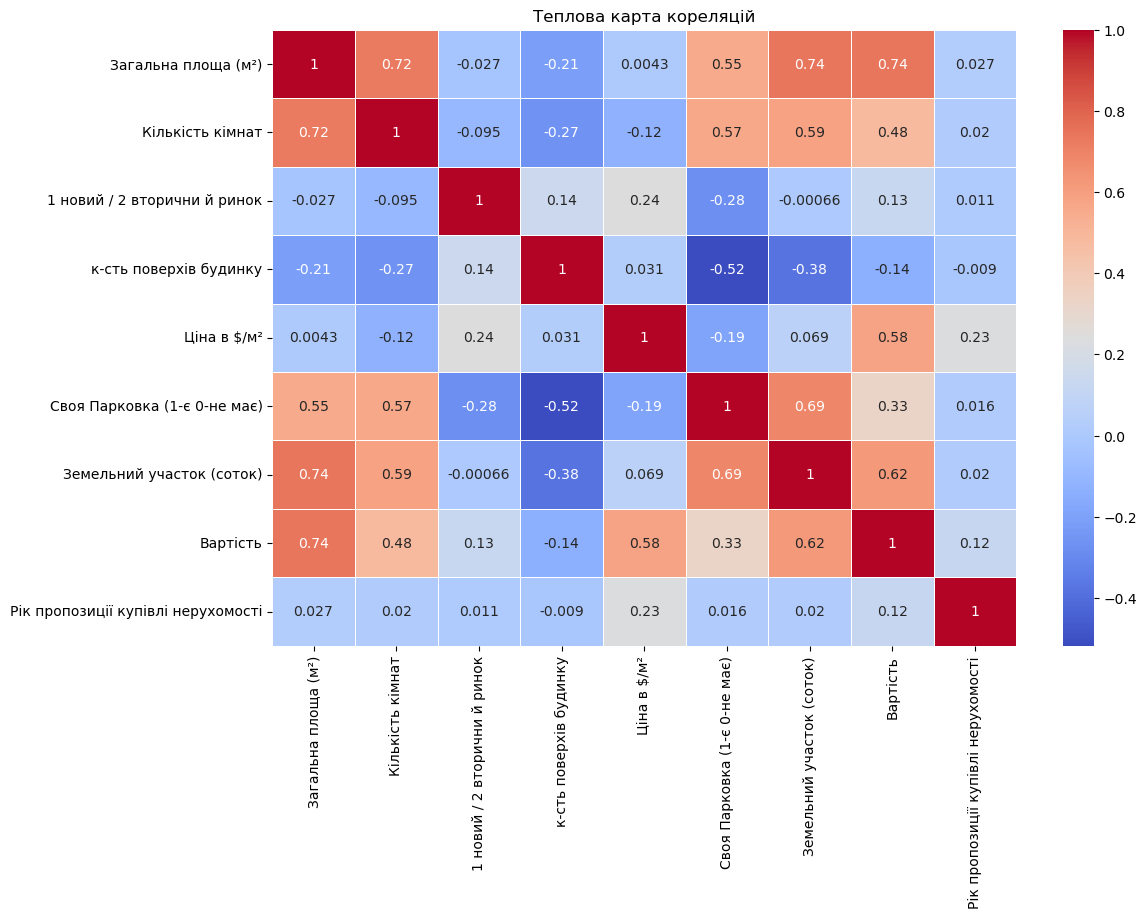

In [54]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Теплова карта кореляцій')
plt.show()



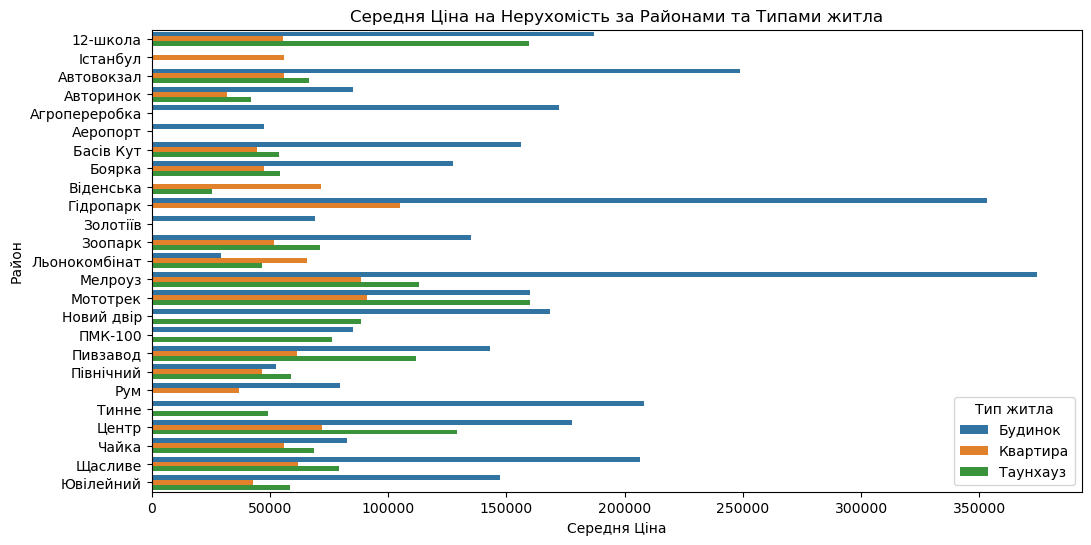

In [20]:
# Групування даних за районом та типом житла та обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка "bar plot" з розділенням за типом житла
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', hue='Тип житла', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами та Типами житла')
plt.show()


In [22]:
# Виведення загальної інформації про датасет
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Район                               2314 non-null   object
 1   Тип житла                           2314 non-null   object
 2   Загальна площа (м²)                 2314 non-null   int64 
 3   Кількість кімнат                    2314 non-null   int64 
 4   1 новий / 2 вторични й ринок        2314 non-null   int64 
 5   к-сть поверхів будинку              2314 non-null   int64 
 6   Ціна в $/м²                         2314 non-null   int64 
 7   Своя Парковка (1-є 0-не має)        2314 non-null   int64 
 8   Земельний участок (соток)           2314 non-null   int64 
 9   Вартість                            2314 non-null   int64 
 10  Рік пропозиції купівлі нерухомості  2314 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 199.0+ KB
None


In [24]:
# Групування даних за роками і обчислення середнього значення цін
average_prices_by_year = df.groupby(['Рік пропозиції купівлі нерухомості'])['Вартість'].mean().reset_index()

# Додавання стовпця для відсотку зміни
average_prices_by_year['Відсоток зміни'] = average_prices_by_year['Вартість'].pct_change() * 100

# Вивід результату
print(average_prices_by_year)

   Рік пропозиції купівлі нерухомості      Вартість  Відсоток зміни
0                                2020  66860.872624             NaN
1                                2021  77502.884007       15.916650
2                                2022  89911.518900       16.010546
3                                2023  90434.551020        0.581719


In [25]:
# забираю стовпчики які мають менше залежностей з вартістю нерухомості за даними теплової карти кореляції

columns_to_drop = ['к-сть поверхів будинку', 'Своя Парковка (1-є 0-не має)', '1 новий / 2 вторични й ринок', 'Рік пропозиції купівлі нерухомості']
df = df.drop(columns=columns_to_drop, axis=1)

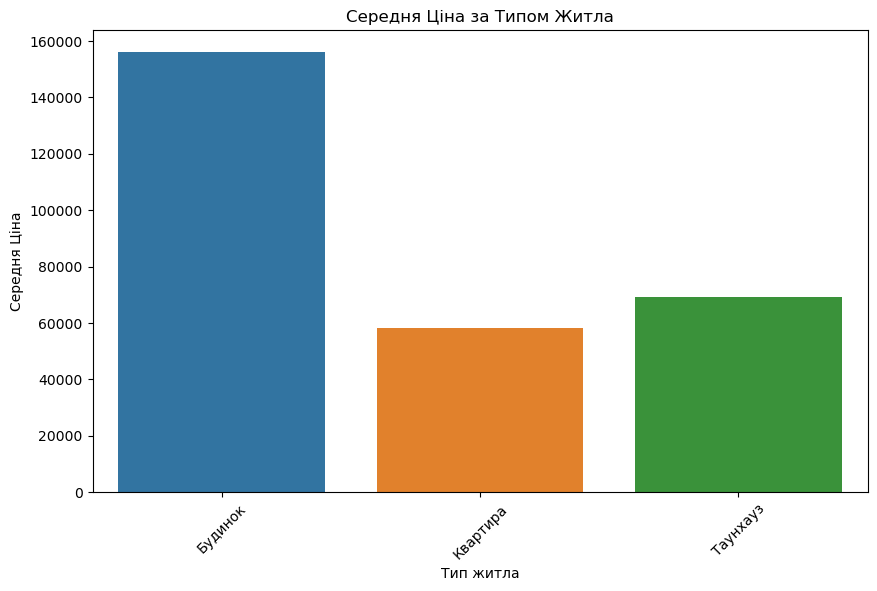

In [26]:
# Групування даних за типом житла і обчислення середньої ціни
grouped_data = df.groupby('Тип житла')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(10, 6))
sns.barplot(x='Тип житла', y='Вартість', data=grouped_data)
plt.xlabel('Тип житла')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла')
plt.xticks(rotation=45)  
# Обертання підписів по вісі X для кращої читабельності
plt.show()


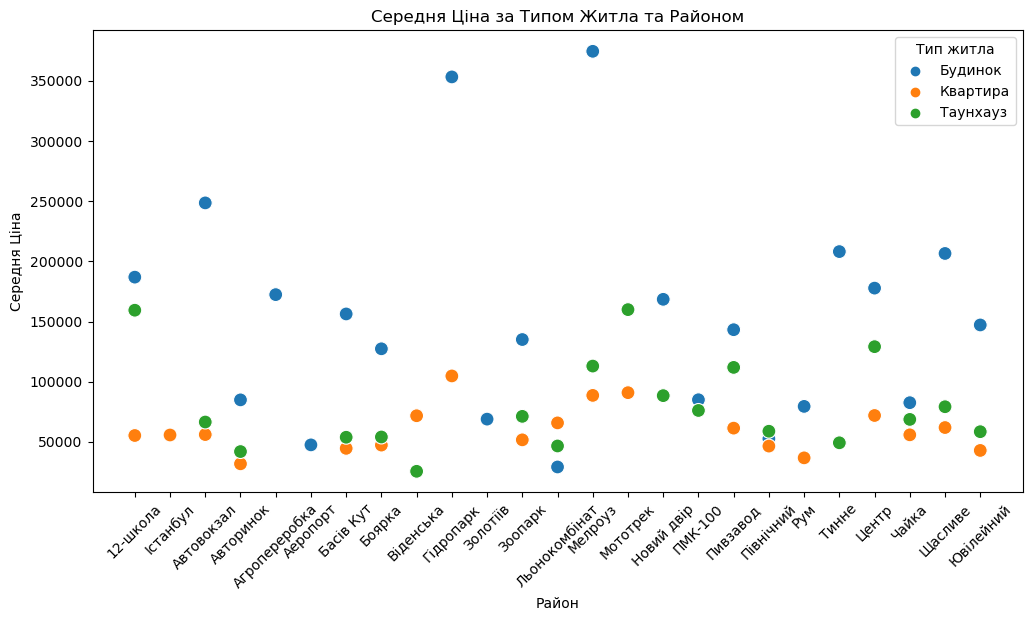

In [27]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

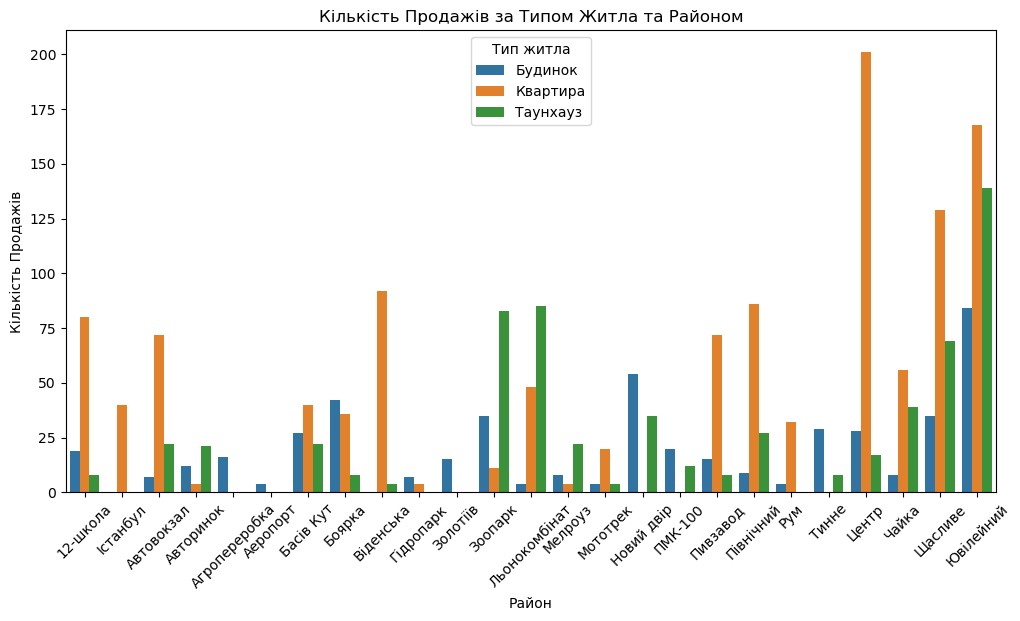

In [28]:
# Групування даних за районом і типом житла і підрахунок кількості виставлених на продажу об'єктів
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Район', y='Вартість', hue='Тип житла', data=count_data)
plt.xlabel('Район')
plt.ylabel('Кількість Продажів')
plt.title('Кількість Продажів за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()


In [29]:
# Замінюю категоріальні значення типу житла на числові
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# Перегляньте оновлений датасет
df.head()

,Район,Тип житла,Загальна площа (м²),Кількість кімнат,Ціна в $/м²,Земельний участок (соток),Вартість
0,12-школа,3,59,3,1644,4,96996
1,12-школа,3,90,2,1500,6,135000
2,12-школа,2,151,3,1656,4,250056
3,12-школа,3,240,4,1417,7,340080
4,12-школа,3,90,2,1500,6,135000


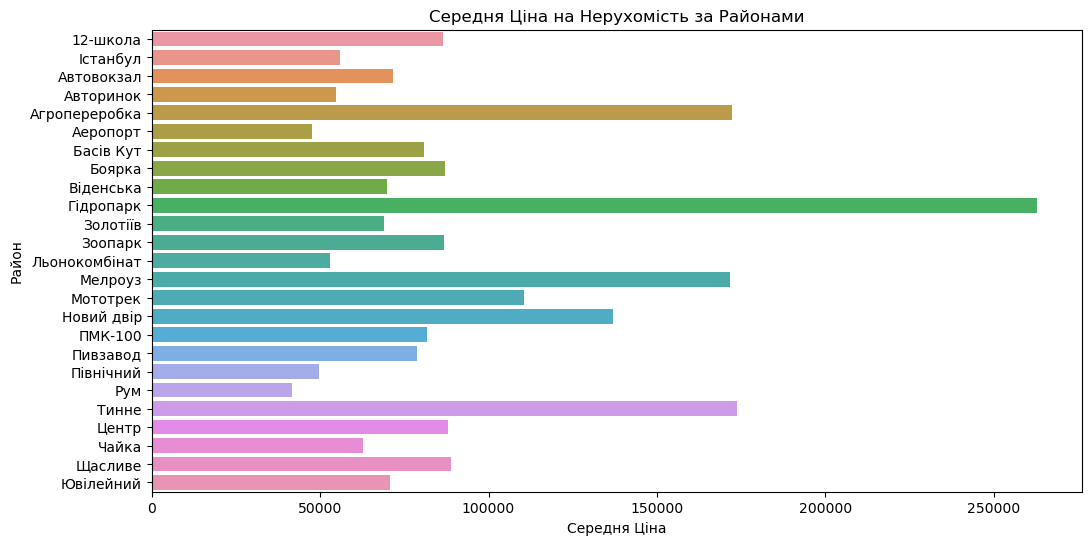

In [30]:
# Групування даних за районом і обчислення середньої ціни
grouped_data = df.groupby('Район')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами')
plt.show()


In [57]:
# Переводимо категоріальні ознаки стовпчика "Район" треба перевести в числовий формат. 
# Для цього використовуємо One-Hot Encoding
df = pd.get_dummies(df, columns=['Район'])

In [58]:
# Пробуємо створити модель лінійної регресії
model = LinearRegression()

# Тренування моделі на навчальних даних
model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
accuracy = model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Linear Regression: {accuracy}')

y_pred_linear = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (MSE) of Linear Regression: {mse_linear}')


Accuracy (R-squared) of Linear Regression: 0.9039820811357304
Mean Squared Error (MSE) of Linear Regression: 617262954.4857326


In [59]:
# Пробуємо використовувати ансамблі, створимо модель випадкового лісу
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Тренування моделі на навчальних даних
rf_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
rf_accuracy = rf_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Random Forest: {rf_accuracy}')

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) of Random Forest: {mse_rf}')

Accuracy (R-squared) of Random Forest: 0.998018348467225
Mean Squared Error (MSE) of Random Forest: 12739289.648747522


In [55]:
# Тепер пробуємо градієнтний бустинг:

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Тренування моделі на навчальних даних
gb_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
gb_accuracy = gb_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Gradient Boosting: {gb_accuracy}')

y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error (MSE) of Gradient Boosting: {mse_gb}')

Accuracy (R-squared) of Gradient Boosting: 0.992232792935521
Mean Squared Error (MSE) of Gradient Boosting: 49932442.167384416


In [32]:
# тепер пробуємо створити та навчати модель нейроної мережі для задачі регресії та подивимось на результати

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Стандартизація ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Створення та компіляція
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Один нейрон в вихідному шарі для регресії
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Навчання моделі
model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_split=0.2)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

Epoch 1/10000
47/47 [==============================] - 0s 2ms/step - loss: 13440466944.0000 - val_loss: 8740078592.0000
Epoch 2/10000
47/47 [==============================] - 0s 856us/step - loss: 13438845952.0000 - val_loss: 8737812480.0000
Epoch 3/10000
47/47 [==============================] - 0s 815us/step - loss: 13434090496.0000 - val_loss: 8731924480.0000
Epoch 4/10000
47/47 [==============================] - 0s 787us/step - loss: 13423083520.0000 - val_loss: 8719935488.0000
Epoch 5/10000
47/47 [==============================] - 0s 816us/step - loss: 13401692160.0000 - val_loss: 8698702848.0000
Epoch 6/10000
47/47 [==============================] - 0s 785us/step - loss: 13367696384.0000 - val_loss: 8666750976.0000
Epoch 7/10000
47/47 [==============================] - 0s 782us/step - loss: 13317416960.0000 - val_loss: 8621990912.0000
Epoch 8/10000
47/47 [==============================] - 0s 846us/step - loss: 13247524864.0000 - val_loss: 8563630592.0000
Epoch 9/10000
47/47 [=====

47/47 [==============================] - 0s 781us/step - loss: 1327452544.0000 - val_loss: 928505472.0000
Epoch 69/10000
47/47 [==============================] - 0s 799us/step - loss: 1301629312.0000 - val_loss: 915686592.0000
Epoch 70/10000
47/47 [==============================] - 0s 742us/step - loss: 1276493824.0000 - val_loss: 906075584.0000
Epoch 71/10000
47/47 [==============================] - 0s 760us/step - loss: 1252893568.0000 - val_loss: 893203328.0000
Epoch 72/10000
47/47 [==============================] - 0s 752us/step - loss: 1229555456.0000 - val_loss: 883218752.0000
Epoch 73/10000
47/47 [==============================] - 0s 772us/step - loss: 1207255936.0000 - val_loss: 871634688.0000
Epoch 74/10000
47/47 [==============================] - 0s 762us/step - loss: 1185685632.0000 - val_loss: 867537280.0000
Epoch 75/10000
47/47 [==============================] - 0s 747us/step - loss: 1163334528.0000 - val_loss: 859418496.0000
Epoch 76/10000
47/47 [=========================

Epoch 136/10000
47/47 [==============================] - 0s 779us/step - loss: 519164512.0000 - val_loss: 545378816.0000
Epoch 137/10000
47/47 [==============================] - 0s 795us/step - loss: 515320448.0000 - val_loss: 546847104.0000
Epoch 138/10000
47/47 [==============================] - 0s 748us/step - loss: 509632512.0000 - val_loss: 541068800.0000
Epoch 139/10000
47/47 [==============================] - 0s 768us/step - loss: 505185408.0000 - val_loss: 542804672.0000
Epoch 140/10000
47/47 [==============================] - 0s 760us/step - loss: 501077728.0000 - val_loss: 541822080.0000
Epoch 141/10000
47/47 [==============================] - 0s 788us/step - loss: 496644288.0000 - val_loss: 537185728.0000
Epoch 142/10000
47/47 [==============================] - 0s 738us/step - loss: 493406240.0000 - val_loss: 538167616.0000
Epoch 143/10000
47/47 [==============================] - 0s 747us/step - loss: 488695456.0000 - val_loss: 534117696.0000
Epoch 144/10000
47/47 [=========

47/47 [==============================] - 0s 787us/step - loss: 340701984.0000 - val_loss: 418997440.0000
Epoch 204/10000
47/47 [==============================] - 0s 786us/step - loss: 338609760.0000 - val_loss: 417121088.0000
Epoch 205/10000
47/47 [==============================] - 0s 760us/step - loss: 337275648.0000 - val_loss: 417022880.0000
Epoch 206/10000
47/47 [==============================] - 0s 778us/step - loss: 335087328.0000 - val_loss: 410296608.0000
Epoch 207/10000
47/47 [==============================] - 0s 747us/step - loss: 333407360.0000 - val_loss: 409669760.0000
Epoch 208/10000
47/47 [==============================] - 0s 756us/step - loss: 331638048.0000 - val_loss: 406307936.0000
Epoch 209/10000
47/47 [==============================] - 0s 755us/step - loss: 329801888.0000 - val_loss: 412279776.0000
Epoch 210/10000
47/47 [==============================] - 0s 755us/step - loss: 328237568.0000 - val_loss: 407856416.0000
Epoch 211/10000
47/47 [=========================

Epoch 271/10000
47/47 [==============================] - 0s 771us/step - loss: 249531824.0000 - val_loss: 328395744.0000
Epoch 272/10000
47/47 [==============================] - 0s 767us/step - loss: 248522720.0000 - val_loss: 328875680.0000
Epoch 273/10000
47/47 [==============================] - 0s 773us/step - loss: 247573792.0000 - val_loss: 323061056.0000
Epoch 274/10000
47/47 [==============================] - 0s 772us/step - loss: 247262720.0000 - val_loss: 328969152.0000
Epoch 275/10000
47/47 [==============================] - 0s 762us/step - loss: 245910752.0000 - val_loss: 321738208.0000
Epoch 276/10000
47/47 [==============================] - 0s 758us/step - loss: 244682368.0000 - val_loss: 325112352.0000
Epoch 277/10000
47/47 [==============================] - 0s 757us/step - loss: 243605904.0000 - val_loss: 324097280.0000
Epoch 278/10000
47/47 [==============================] - 0s 762us/step - loss: 242494624.0000 - val_loss: 320899680.0000
Epoch 279/10000
47/47 [=========

47/47 [==============================] - 0s 782us/step - loss: 196842336.0000 - val_loss: 271155584.0000
Epoch 339/10000
47/47 [==============================] - 0s 772us/step - loss: 196120992.0000 - val_loss: 269454400.0000
Epoch 340/10000
47/47 [==============================] - 0s 774us/step - loss: 195653056.0000 - val_loss: 272251840.0000
Epoch 341/10000
47/47 [==============================] - 0s 782us/step - loss: 195260000.0000 - val_loss: 269934496.0000
Epoch 342/10000
47/47 [==============================] - 0s 755us/step - loss: 194221824.0000 - val_loss: 268564928.0000
Epoch 343/10000
47/47 [==============================] - 0s 760us/step - loss: 193724704.0000 - val_loss: 269504000.0000
Epoch 344/10000
47/47 [==============================] - 0s 770us/step - loss: 193030928.0000 - val_loss: 268912640.0000
Epoch 345/10000
47/47 [==============================] - 0s 757us/step - loss: 192244144.0000 - val_loss: 268821664.0000
Epoch 346/10000
47/47 [=========================

Epoch 406/10000
47/47 [==============================] - 0s 793us/step - loss: 159894096.0000 - val_loss: 234802944.0000
Epoch 407/10000
47/47 [==============================] - 0s 760us/step - loss: 159519200.0000 - val_loss: 234056400.0000
Epoch 408/10000
47/47 [==============================] - 0s 756us/step - loss: 159143840.0000 - val_loss: 235517200.0000
Epoch 409/10000
47/47 [==============================] - 0s 772us/step - loss: 158659984.0000 - val_loss: 233586928.0000
Epoch 410/10000
47/47 [==============================] - 0s 763us/step - loss: 157944432.0000 - val_loss: 234534944.0000
Epoch 411/10000
47/47 [==============================] - 0s 758us/step - loss: 157543200.0000 - val_loss: 233949792.0000
Epoch 412/10000
47/47 [==============================] - 0s 753us/step - loss: 157614208.0000 - val_loss: 233492896.0000
Epoch 413/10000
47/47 [==============================] - 0s 775us/step - loss: 156824640.0000 - val_loss: 231467984.0000
Epoch 414/10000
47/47 [=========

47/47 [==============================] - 0s 773us/step - loss: 134418704.0000 - val_loss: 211994272.0000
Epoch 474/10000
47/47 [==============================] - 0s 776us/step - loss: 134103448.0000 - val_loss: 212011904.0000
Epoch 475/10000
47/47 [==============================] - 0s 782us/step - loss: 133909776.0000 - val_loss: 211843616.0000
Epoch 476/10000
47/47 [==============================] - 0s 767us/step - loss: 133642208.0000 - val_loss: 210558320.0000
Epoch 477/10000
47/47 [==============================] - 0s 754us/step - loss: 133174632.0000 - val_loss: 210951312.0000
Epoch 478/10000
47/47 [==============================] - 0s 764us/step - loss: 132695256.0000 - val_loss: 211919040.0000
Epoch 479/10000
47/47 [==============================] - 0s 747us/step - loss: 132648968.0000 - val_loss: 209541376.0000
Epoch 480/10000
47/47 [==============================] - 0s 761us/step - loss: 133004656.0000 - val_loss: 207150768.0000
Epoch 481/10000
47/47 [=========================

Epoch 541/10000
47/47 [==============================] - 0s 806us/step - loss: 115473504.0000 - val_loss: 192269072.0000
Epoch 542/10000
47/47 [==============================] - 0s 770us/step - loss: 115196384.0000 - val_loss: 192880976.0000
Epoch 543/10000
47/47 [==============================] - 0s 768us/step - loss: 114838024.0000 - val_loss: 189757504.0000
Epoch 544/10000
47/47 [==============================] - 0s 751us/step - loss: 114424584.0000 - val_loss: 190390224.0000
Epoch 545/10000
47/47 [==============================] - 0s 741us/step - loss: 114377256.0000 - val_loss: 190364240.0000
Epoch 546/10000
47/47 [==============================] - 0s 763us/step - loss: 114071272.0000 - val_loss: 188788016.0000
Epoch 547/10000
47/47 [==============================] - 0s 762us/step - loss: 113730808.0000 - val_loss: 187496816.0000
Epoch 548/10000
47/47 [==============================] - 0s 774us/step - loss: 113875288.0000 - val_loss: 186229600.0000
Epoch 549/10000
47/47 [=========

47/47 [==============================] - 0s 781us/step - loss: 102042720.0000 - val_loss: 176517712.0000
Epoch 609/10000
47/47 [==============================] - 0s 741us/step - loss: 101287992.0000 - val_loss: 173978256.0000
Epoch 610/10000
47/47 [==============================] - 0s 803us/step - loss: 101496576.0000 - val_loss: 176507200.0000
Epoch 611/10000
47/47 [==============================] - 0s 771us/step - loss: 100983904.0000 - val_loss: 173925472.0000
Epoch 612/10000
47/47 [==============================] - 0s 768us/step - loss: 100899592.0000 - val_loss: 174985776.0000
Epoch 613/10000
47/47 [==============================] - 0s 749us/step - loss: 100784304.0000 - val_loss: 174500144.0000
Epoch 614/10000
47/47 [==============================] - 0s 772us/step - loss: 100613448.0000 - val_loss: 173535216.0000
Epoch 615/10000
47/47 [==============================] - 0s 757us/step - loss: 100297280.0000 - val_loss: 174373408.0000
Epoch 616/10000
47/47 [=========================

47/47 [==============================] - 0s 769us/step - loss: 90603040.0000 - val_loss: 161928112.0000
Epoch 677/10000
47/47 [==============================] - 0s 787us/step - loss: 90644888.0000 - val_loss: 162916752.0000
Epoch 678/10000
47/47 [==============================] - 0s 786us/step - loss: 90066720.0000 - val_loss: 162569584.0000
Epoch 679/10000
47/47 [==============================] - 0s 766us/step - loss: 90133984.0000 - val_loss: 162881568.0000
Epoch 680/10000
47/47 [==============================] - 0s 740us/step - loss: 89977912.0000 - val_loss: 162531184.0000
Epoch 681/10000
47/47 [==============================] - 0s 780us/step - loss: 89741352.0000 - val_loss: 161256256.0000
Epoch 682/10000
47/47 [==============================] - 0s 758us/step - loss: 89738232.0000 - val_loss: 160920960.0000
Epoch 683/10000
47/47 [==============================] - 0s 738us/step - loss: 89766616.0000 - val_loss: 160899584.0000
Epoch 684/10000
47/47 [==============================] -

47/47 [==============================] - 0s 794us/step - loss: 82275448.0000 - val_loss: 150590672.0000
Epoch 745/10000
47/47 [==============================] - 0s 753us/step - loss: 82283664.0000 - val_loss: 150959680.0000
Epoch 746/10000
47/47 [==============================] - 0s 768us/step - loss: 82232816.0000 - val_loss: 150058512.0000
Epoch 747/10000
47/47 [==============================] - 0s 800us/step - loss: 81785112.0000 - val_loss: 151437648.0000
Epoch 748/10000
47/47 [==============================] - 0s 767us/step - loss: 81979208.0000 - val_loss: 151529120.0000
Epoch 749/10000
47/47 [==============================] - 0s 781us/step - loss: 81800512.0000 - val_loss: 150726416.0000
Epoch 750/10000
47/47 [==============================] - 0s 761us/step - loss: 81484936.0000 - val_loss: 151283920.0000
Epoch 751/10000
47/47 [==============================] - 0s 757us/step - loss: 81638088.0000 - val_loss: 150544224.0000
Epoch 752/10000
47/47 [==============================] -

47/47 [==============================] - 0s 778us/step - loss: 74871776.0000 - val_loss: 140135968.0000
Epoch 813/10000
47/47 [==============================] - 0s 793us/step - loss: 74725736.0000 - val_loss: 139112224.0000
Epoch 814/10000
47/47 [==============================] - 0s 769us/step - loss: 74738144.0000 - val_loss: 139493376.0000
Epoch 815/10000
47/47 [==============================] - 0s 754us/step - loss: 74707808.0000 - val_loss: 139130592.0000
Epoch 816/10000
47/47 [==============================] - 0s 749us/step - loss: 74451048.0000 - val_loss: 142213136.0000
Epoch 817/10000
47/47 [==============================] - 0s 755us/step - loss: 74288280.0000 - val_loss: 139627776.0000
Epoch 818/10000
47/47 [==============================] - 0s 781us/step - loss: 74185608.0000 - val_loss: 138371200.0000
Epoch 819/10000
47/47 [==============================] - 0s 744us/step - loss: 74180464.0000 - val_loss: 139469376.0000
Epoch 820/10000
47/47 [==============================] -

47/47 [==============================] - 0s 807us/step - loss: 67376248.0000 - val_loss: 130176304.0000
Epoch 881/10000
47/47 [==============================] - 0s 784us/step - loss: 67348608.0000 - val_loss: 130262528.0000
Epoch 882/10000
47/47 [==============================] - 0s 771us/step - loss: 67177104.0000 - val_loss: 127737392.0000
Epoch 883/10000
47/47 [==============================] - 0s 782us/step - loss: 66914280.0000 - val_loss: 129172296.0000
Epoch 884/10000
47/47 [==============================] - 0s 760us/step - loss: 66936600.0000 - val_loss: 129716144.0000
Epoch 885/10000
47/47 [==============================] - 0s 766us/step - loss: 66900584.0000 - val_loss: 130108080.0000
Epoch 886/10000
47/47 [==============================] - 0s 759us/step - loss: 66701648.0000 - val_loss: 128305912.0000
Epoch 887/10000
47/47 [==============================] - 0s 748us/step - loss: 66602200.0000 - val_loss: 129139624.0000
Epoch 888/10000
47/47 [==============================] -

47/47 [==============================] - 0s 795us/step - loss: 59395004.0000 - val_loss: 118565432.0000
Epoch 949/10000
47/47 [==============================] - 0s 786us/step - loss: 59649916.0000 - val_loss: 116799144.0000
Epoch 950/10000
47/47 [==============================] - 0s 761us/step - loss: 59375136.0000 - val_loss: 116613728.0000
Epoch 951/10000
47/47 [==============================] - 0s 753us/step - loss: 59170572.0000 - val_loss: 118641984.0000
Epoch 952/10000
47/47 [==============================] - 0s 774us/step - loss: 59213468.0000 - val_loss: 118000088.0000
Epoch 953/10000
47/47 [==============================] - 0s 742us/step - loss: 59094524.0000 - val_loss: 118620976.0000
Epoch 954/10000
47/47 [==============================] - 0s 773us/step - loss: 58693736.0000 - val_loss: 117344536.0000
Epoch 955/10000
47/47 [==============================] - 0s 757us/step - loss: 58645060.0000 - val_loss: 117041264.0000
Epoch 956/10000
47/47 [==============================] -

47/47 [==============================] - 0s 777us/step - loss: 49842000.0000 - val_loss: 104970776.0000
Epoch 1017/10000
47/47 [==============================] - 0s 791us/step - loss: 49491784.0000 - val_loss: 103549784.0000
Epoch 1018/10000
47/47 [==============================] - 0s 779us/step - loss: 49407240.0000 - val_loss: 103781984.0000
Epoch 1019/10000
47/47 [==============================] - 0s 798us/step - loss: 49252584.0000 - val_loss: 103759632.0000
Epoch 1020/10000
47/47 [==============================] - 0s 781us/step - loss: 49108920.0000 - val_loss: 103633536.0000
Epoch 1021/10000
47/47 [==============================] - 0s 766us/step - loss: 48977416.0000 - val_loss: 103220096.0000
Epoch 1022/10000
47/47 [==============================] - 0s 759us/step - loss: 48816444.0000 - val_loss: 103135336.0000
Epoch 1023/10000
47/47 [==============================] - 0s 752us/step - loss: 48507816.0000 - val_loss: 103199000.0000
Epoch 1024/10000
47/47 [=========================

47/47 [==============================] - 0s 791us/step - loss: 37605088.0000 - val_loss: 85213280.0000
Epoch 1085/10000
47/47 [==============================] - 0s 794us/step - loss: 37319668.0000 - val_loss: 84462328.0000
Epoch 1086/10000
47/47 [==============================] - 0s 771us/step - loss: 37085940.0000 - val_loss: 84779520.0000
Epoch 1087/10000
47/47 [==============================] - 0s 764us/step - loss: 36920844.0000 - val_loss: 84273784.0000
Epoch 1088/10000
47/47 [==============================] - 0s 752us/step - loss: 36896656.0000 - val_loss: 83952928.0000
Epoch 1089/10000
47/47 [==============================] - 0s 742us/step - loss: 36496720.0000 - val_loss: 82929640.0000
Epoch 1090/10000
47/47 [==============================] - 0s 769us/step - loss: 36423576.0000 - val_loss: 82715864.0000
Epoch 1091/10000
47/47 [==============================] - 0s 738us/step - loss: 36155456.0000 - val_loss: 82477376.0000
Epoch 1092/10000
47/47 [==============================] -

47/47 [==============================] - 0s 805us/step - loss: 25170196.0000 - val_loss: 61527936.0000
Epoch 1153/10000
47/47 [==============================] - 0s 775us/step - loss: 24938862.0000 - val_loss: 61706512.0000
Epoch 1154/10000
47/47 [==============================] - 0s 769us/step - loss: 24868178.0000 - val_loss: 61216968.0000
Epoch 1155/10000
47/47 [==============================] - 0s 725us/step - loss: 24738058.0000 - val_loss: 61428264.0000
Epoch 1156/10000
47/47 [==============================] - 0s 750us/step - loss: 24539758.0000 - val_loss: 60677708.0000
Epoch 1157/10000
47/47 [==============================] - 0s 764us/step - loss: 24316848.0000 - val_loss: 59984508.0000
Epoch 1158/10000
47/47 [==============================] - 0s 779us/step - loss: 24182498.0000 - val_loss: 60397084.0000
Epoch 1159/10000
47/47 [==============================] - 0s 762us/step - loss: 24051720.0000 - val_loss: 59608764.0000
Epoch 1160/10000
47/47 [==============================] -

47/47 [==============================] - 0s 769us/step - loss: 16981146.0000 - val_loss: 44035856.0000
Epoch 1221/10000
47/47 [==============================] - 0s 788us/step - loss: 16879592.0000 - val_loss: 43993084.0000
Epoch 1222/10000
47/47 [==============================] - 0s 780us/step - loss: 16794378.0000 - val_loss: 44077288.0000
Epoch 1223/10000
47/47 [==============================] - 0s 752us/step - loss: 16676387.0000 - val_loss: 43251600.0000
Epoch 1224/10000
47/47 [==============================] - 0s 758us/step - loss: 16761981.0000 - val_loss: 43823472.0000
Epoch 1225/10000
47/47 [==============================] - 0s 770us/step - loss: 16538840.0000 - val_loss: 42211464.0000
Epoch 1226/10000
47/47 [==============================] - 0s 761us/step - loss: 16519989.0000 - val_loss: 43317024.0000
Epoch 1227/10000
47/47 [==============================] - 0s 743us/step - loss: 16347809.0000 - val_loss: 42532816.0000
Epoch 1228/10000
47/47 [==============================] -

47/47 [==============================] - 0s 774us/step - loss: 12109010.0000 - val_loss: 33694224.0000
Epoch 1289/10000
47/47 [==============================] - 0s 783us/step - loss: 12028514.0000 - val_loss: 34027036.0000
Epoch 1290/10000
47/47 [==============================] - 0s 767us/step - loss: 12075449.0000 - val_loss: 33525156.0000
Epoch 1291/10000
47/47 [==============================] - 0s 753us/step - loss: 11832385.0000 - val_loss: 33108904.0000
Epoch 1292/10000
47/47 [==============================] - 0s 763us/step - loss: 11833264.0000 - val_loss: 32604234.0000
Epoch 1293/10000
47/47 [==============================] - 0s 769us/step - loss: 11753163.0000 - val_loss: 32850168.0000
Epoch 1294/10000
47/47 [==============================] - 0s 769us/step - loss: 11676004.0000 - val_loss: 33264814.0000
Epoch 1295/10000
47/47 [==============================] - 0s 772us/step - loss: 11664305.0000 - val_loss: 32928542.0000
Epoch 1296/10000
47/47 [==============================] -

47/47 [==============================] - 0s 765us/step - loss: 8871933.0000 - val_loss: 26019004.0000
Epoch 1357/10000
47/47 [==============================] - 0s 784us/step - loss: 8867029.0000 - val_loss: 25309520.0000
Epoch 1358/10000
47/47 [==============================] - 0s 757us/step - loss: 8866422.0000 - val_loss: 25108054.0000
Epoch 1359/10000
47/47 [==============================] - 0s 784us/step - loss: 8892462.0000 - val_loss: 24970474.0000
Epoch 1360/10000
47/47 [==============================] - 0s 748us/step - loss: 8782889.0000 - val_loss: 24948118.0000
Epoch 1361/10000
47/47 [==============================] - 0s 762us/step - loss: 8723502.0000 - val_loss: 25179078.0000
Epoch 1362/10000
47/47 [==============================] - 0s 753us/step - loss: 8652652.0000 - val_loss: 24562964.0000
Epoch 1363/10000
47/47 [==============================] - 0s 752us/step - loss: 8619255.0000 - val_loss: 25069044.0000
Epoch 1364/10000
47/47 [==============================] - 0s 801u

Epoch 1425/10000
47/47 [==============================] - 0s 781us/step - loss: 6659752.0000 - val_loss: 20376258.0000
Epoch 1426/10000
47/47 [==============================] - 0s 769us/step - loss: 6642817.5000 - val_loss: 20286066.0000
Epoch 1427/10000
47/47 [==============================] - 0s 785us/step - loss: 6588812.5000 - val_loss: 19731786.0000
Epoch 1428/10000
47/47 [==============================] - 0s 761us/step - loss: 6581416.0000 - val_loss: 19715122.0000
Epoch 1429/10000
47/47 [==============================] - 0s 763us/step - loss: 6561766.5000 - val_loss: 20631280.0000
Epoch 1430/10000
47/47 [==============================] - 0s 752us/step - loss: 6568186.0000 - val_loss: 19481588.0000
Epoch 1431/10000
47/47 [==============================] - 0s 760us/step - loss: 6513527.0000 - val_loss: 20436174.0000
Epoch 1432/10000
47/47 [==============================] - 0s 749us/step - loss: 6461108.5000 - val_loss: 19420478.0000
Epoch 1433/10000
47/47 [========================

Epoch 1494/10000
47/47 [==============================] - 0s 784us/step - loss: 5094352.5000 - val_loss: 16493107.0000
Epoch 1495/10000
47/47 [==============================] - 0s 797us/step - loss: 5171992.5000 - val_loss: 17455668.0000
Epoch 1496/10000
47/47 [==============================] - 0s 761us/step - loss: 5101196.0000 - val_loss: 16772731.0000
Epoch 1497/10000
47/47 [==============================] - 0s 750us/step - loss: 5032966.0000 - val_loss: 16336507.0000
Epoch 1498/10000
47/47 [==============================] - 0s 772us/step - loss: 5034309.0000 - val_loss: 16203808.0000
Epoch 1499/10000
47/47 [==============================] - 0s 749us/step - loss: 5010261.0000 - val_loss: 16160331.0000
Epoch 1500/10000
47/47 [==============================] - 0s 768us/step - loss: 4975648.0000 - val_loss: 16356453.0000
Epoch 1501/10000
47/47 [==============================] - 0s 752us/step - loss: 4945126.5000 - val_loss: 16158462.0000
Epoch 1502/10000
47/47 [========================

Epoch 1563/10000
47/47 [==============================] - 0s 813us/step - loss: 4006986.5000 - val_loss: 13151685.0000
Epoch 1564/10000
47/47 [==============================] - 0s 822us/step - loss: 4044148.2500 - val_loss: 13720968.0000
Epoch 1565/10000
47/47 [==============================] - 0s 839us/step - loss: 4109899.7500 - val_loss: 13217589.0000
Epoch 1566/10000
47/47 [==============================] - 0s 825us/step - loss: 3991730.7500 - val_loss: 13601971.0000
Epoch 1567/10000
47/47 [==============================] - 0s 818us/step - loss: 3942308.7500 - val_loss: 13566806.0000
Epoch 1568/10000
47/47 [==============================] - 0s 819us/step - loss: 3969308.7500 - val_loss: 13617761.0000
Epoch 1569/10000
47/47 [==============================] - 0s 805us/step - loss: 3972673.0000 - val_loss: 13620797.0000
Epoch 1570/10000
47/47 [==============================] - 0s 810us/step - loss: 3909338.2500 - val_loss: 13744683.0000
Epoch 1571/10000
47/47 [========================

Epoch 1632/10000
47/47 [==============================] - 0s 793us/step - loss: 3248910.5000 - val_loss: 11060613.0000
Epoch 1633/10000
47/47 [==============================] - 0s 789us/step - loss: 3196479.0000 - val_loss: 11666265.0000
Epoch 1634/10000
47/47 [==============================] - 0s 771us/step - loss: 3203089.0000 - val_loss: 11729542.0000
Epoch 1635/10000
47/47 [==============================] - 0s 766us/step - loss: 3193162.7500 - val_loss: 11674592.0000
Epoch 1636/10000
47/47 [==============================] - 0s 777us/step - loss: 3212593.5000 - val_loss: 11541302.0000
Epoch 1637/10000
47/47 [==============================] - 0s 771us/step - loss: 3129264.0000 - val_loss: 11881261.0000
Epoch 1638/10000
47/47 [==============================] - 0s 752us/step - loss: 3135630.2500 - val_loss: 11273719.0000
Epoch 1639/10000
47/47 [==============================] - 0s 745us/step - loss: 3123362.5000 - val_loss: 11344659.0000
Epoch 1640/10000
47/47 [========================

Epoch 1701/10000
47/47 [==============================] - 0s 784us/step - loss: 2559251.0000 - val_loss: 9436023.0000
Epoch 1702/10000
47/47 [==============================] - 0s 786us/step - loss: 2638424.5000 - val_loss: 9981530.0000
Epoch 1703/10000
47/47 [==============================] - 0s 751us/step - loss: 2536045.5000 - val_loss: 9401690.0000
Epoch 1704/10000
47/47 [==============================] - 0s 763us/step - loss: 2540153.5000 - val_loss: 9543527.0000
Epoch 1705/10000
47/47 [==============================] - 0s 751us/step - loss: 2508261.0000 - val_loss: 9997718.0000
Epoch 1706/10000
47/47 [==============================] - 0s 754us/step - loss: 2513737.2500 - val_loss: 9550034.0000
Epoch 1707/10000
47/47 [==============================] - 0s 760us/step - loss: 2552018.2500 - val_loss: 9748771.0000
Epoch 1708/10000
47/47 [==============================] - 0s 820us/step - loss: 2505969.5000 - val_loss: 9524708.0000
Epoch 1709/10000
47/47 [==============================] 

47/47 [==============================] - 0s 794us/step - loss: 2049474.3750 - val_loss: 8547938.0000
Epoch 1771/10000
47/47 [==============================] - 0s 781us/step - loss: 2083536.7500 - val_loss: 8248122.0000
Epoch 1772/10000
47/47 [==============================] - 0s 774us/step - loss: 2096027.8750 - val_loss: 8545350.0000
Epoch 1773/10000
47/47 [==============================] - 0s 756us/step - loss: 2039713.7500 - val_loss: 8224720.5000
Epoch 1774/10000
47/47 [==============================] - 0s 766us/step - loss: 2043007.2500 - val_loss: 8074617.5000
Epoch 1775/10000
47/47 [==============================] - 0s 750us/step - loss: 2038849.3750 - val_loss: 8535351.0000
Epoch 1776/10000
47/47 [==============================] - 0s 793us/step - loss: 1975134.7500 - val_loss: 8584171.0000
Epoch 1777/10000
47/47 [==============================] - 0s 767us/step - loss: 2000150.1250 - val_loss: 8223726.0000
Epoch 1778/10000
47/47 [==============================] - 0s 745us/step -

47/47 [==============================] - 0s 780us/step - loss: 1639912.2500 - val_loss: 7677556.0000
Epoch 1840/10000
47/47 [==============================] - 0s 787us/step - loss: 1639013.3750 - val_loss: 7405058.0000
Epoch 1841/10000
47/47 [==============================] - 0s 766us/step - loss: 1635811.7500 - val_loss: 6962789.5000
Epoch 1842/10000
47/47 [==============================] - 0s 774us/step - loss: 1630113.0000 - val_loss: 7231145.0000
Epoch 1843/10000
47/47 [==============================] - 0s 765us/step - loss: 1622447.0000 - val_loss: 7558566.5000
Epoch 1844/10000
47/47 [==============================] - 0s 776us/step - loss: 1595942.2500 - val_loss: 7006992.0000
Epoch 1845/10000
47/47 [==============================] - 0s 787us/step - loss: 1675115.2500 - val_loss: 6938516.5000
Epoch 1846/10000
47/47 [==============================] - 0s 780us/step - loss: 1618571.3750 - val_loss: 7197345.5000
Epoch 1847/10000
47/47 [==============================] - 0s 774us/step -

47/47 [==============================] - 0s 773us/step - loss: 1337892.7500 - val_loss: 6181245.5000
Epoch 1909/10000
47/47 [==============================] - 0s 771us/step - loss: 1366206.7500 - val_loss: 6240934.5000
Epoch 1910/10000
47/47 [==============================] - 0s 805us/step - loss: 1344021.7500 - val_loss: 6389448.0000
Epoch 1911/10000
47/47 [==============================] - 0s 786us/step - loss: 1371224.2500 - val_loss: 6364519.0000
Epoch 1912/10000
47/47 [==============================] - 0s 804us/step - loss: 1368975.2500 - val_loss: 6523543.0000
Epoch 1913/10000
47/47 [==============================] - 0s 774us/step - loss: 1331355.1250 - val_loss: 6180926.0000
Epoch 1914/10000
47/47 [==============================] - 0s 795us/step - loss: 1324111.1250 - val_loss: 6598322.5000
Epoch 1915/10000
47/47 [==============================] - 0s 777us/step - loss: 1352307.2500 - val_loss: 6587666.5000
Epoch 1916/10000
47/47 [==============================] - 0s 776us/step -

47/47 [==============================] - 0s 798us/step - loss: 1140999.5000 - val_loss: 6226272.5000
Epoch 1978/10000
47/47 [==============================] - 0s 786us/step - loss: 1132824.6250 - val_loss: 5682904.0000
Epoch 1979/10000
47/47 [==============================] - 0s 790us/step - loss: 1136878.5000 - val_loss: 5814128.0000
Epoch 1980/10000
47/47 [==============================] - 0s 775us/step - loss: 1167944.2500 - val_loss: 5783983.0000
Epoch 1981/10000
47/47 [==============================] - 0s 766us/step - loss: 1156893.6250 - val_loss: 5578639.0000
Epoch 1982/10000
47/47 [==============================] - 0s 735us/step - loss: 1125399.3750 - val_loss: 6037875.0000
Epoch 1983/10000
47/47 [==============================] - 0s 783us/step - loss: 1150132.3750 - val_loss: 5698016.0000
Epoch 1984/10000
47/47 [==============================] - 0s 777us/step - loss: 1129308.2500 - val_loss: 5524170.0000
Epoch 1985/10000
47/47 [==============================] - 0s 770us/step -

47/47 [==============================] - 0s 823us/step - loss: 1003029.3750 - val_loss: 4979617.0000
Epoch 2047/10000
47/47 [==============================] - 0s 792us/step - loss: 978527.5625 - val_loss: 4843688.0000
Epoch 2048/10000
47/47 [==============================] - 0s 814us/step - loss: 990238.2500 - val_loss: 4853851.0000
Epoch 2049/10000
47/47 [==============================] - 0s 742us/step - loss: 1015383.6250 - val_loss: 4799237.0000
Epoch 2050/10000
47/47 [==============================] - 0s 793us/step - loss: 984866.7500 - val_loss: 5042070.0000
Epoch 2051/10000
47/47 [==============================] - 0s 760us/step - loss: 993616.1875 - val_loss: 4843562.0000
Epoch 2052/10000
47/47 [==============================] - 0s 742us/step - loss: 967018.8125 - val_loss: 4904592.5000
Epoch 2053/10000
47/47 [==============================] - 0s 749us/step - loss: 967906.9375 - val_loss: 4837913.0000
Epoch 2054/10000
47/47 [==============================] - 0s 754us/step - loss:

47/47 [==============================] - 0s 823us/step - loss: 884453.8750 - val_loss: 4468299.0000
Epoch 2117/10000
47/47 [==============================] - 0s 791us/step - loss: 874265.7500 - val_loss: 4418833.0000
Epoch 2118/10000
47/47 [==============================] - 0s 781us/step - loss: 867169.3750 - val_loss: 4257629.0000
Epoch 2119/10000
47/47 [==============================] - 0s 764us/step - loss: 858841.6250 - val_loss: 4192810.7500
Epoch 2120/10000
47/47 [==============================] - 0s 779us/step - loss: 877591.0000 - val_loss: 4283610.5000
Epoch 2121/10000
47/47 [==============================] - 0s 778us/step - loss: 870898.6250 - val_loss: 4279491.0000
Epoch 2122/10000
47/47 [==============================] - 0s 787us/step - loss: 866252.6875 - val_loss: 4411523.5000
Epoch 2123/10000
47/47 [==============================] - 0s 750us/step - loss: 876836.8125 - val_loss: 4618923.5000
Epoch 2124/10000
47/47 [==============================] - 0s 794us/step - loss: 8

47/47 [==============================] - 0s 781us/step - loss: 777167.8125 - val_loss: 3929328.5000
Epoch 2187/10000
47/47 [==============================] - 0s 793us/step - loss: 791585.5000 - val_loss: 3942259.5000
Epoch 2188/10000
47/47 [==============================] - 0s 839us/step - loss: 764384.5000 - val_loss: 4237135.5000
Epoch 2189/10000
47/47 [==============================] - 0s 836us/step - loss: 758519.8750 - val_loss: 4195572.5000
Epoch 2190/10000
47/47 [==============================] - 0s 804us/step - loss: 766225.1875 - val_loss: 4154948.0000
Epoch 2191/10000
47/47 [==============================] - 0s 780us/step - loss: 764588.1250 - val_loss: 4155088.7500
Epoch 2192/10000
47/47 [==============================] - 0s 777us/step - loss: 756048.0000 - val_loss: 4364652.0000
Epoch 2193/10000
47/47 [==============================] - 0s 762us/step - loss: 773874.1875 - val_loss: 4470108.5000
Epoch 2194/10000
47/47 [==============================] - 0s 746us/step - loss: 7

47/47 [==============================] - 0s 794us/step - loss: 703125.2500 - val_loss: 3918739.0000
Epoch 2257/10000
47/47 [==============================] - 0s 797us/step - loss: 682536.5000 - val_loss: 4149683.7500
Epoch 2258/10000
47/47 [==============================] - 0s 807us/step - loss: 695149.6250 - val_loss: 3827473.2500
Epoch 2259/10000
47/47 [==============================] - 0s 787us/step - loss: 706781.8125 - val_loss: 4078162.0000
Epoch 2260/10000
47/47 [==============================] - 0s 767us/step - loss: 683525.5000 - val_loss: 3929887.5000
Epoch 2261/10000
47/47 [==============================] - 0s 803us/step - loss: 693744.0000 - val_loss: 3817506.7500
Epoch 2262/10000
47/47 [==============================] - 0s 781us/step - loss: 692471.8125 - val_loss: 3982433.0000
Epoch 2263/10000
47/47 [==============================] - 0s 789us/step - loss: 700455.0625 - val_loss: 3995649.7500
Epoch 2264/10000
47/47 [==============================] - 0s 795us/step - loss: 6

47/47 [==============================] - 0s 783us/step - loss: 629574.6875 - val_loss: 3700721.5000
Epoch 2327/10000
47/47 [==============================] - 0s 803us/step - loss: 634263.5000 - val_loss: 3772748.0000
Epoch 2328/10000
47/47 [==============================] - 0s 784us/step - loss: 643239.1250 - val_loss: 3793190.0000
Epoch 2329/10000
47/47 [==============================] - 0s 755us/step - loss: 653095.0625 - val_loss: 3818302.5000
Epoch 2330/10000
47/47 [==============================] - 0s 747us/step - loss: 627992.5000 - val_loss: 3628702.7500
Epoch 2331/10000
47/47 [==============================] - 0s 793us/step - loss: 637265.0625 - val_loss: 3927974.0000
Epoch 2332/10000
47/47 [==============================] - 0s 781us/step - loss: 649964.2500 - val_loss: 3786942.0000
Epoch 2333/10000
47/47 [==============================] - 0s 773us/step - loss: 629627.8750 - val_loss: 3691112.5000
Epoch 2334/10000
47/47 [==============================] - 0s 760us/step - loss: 6

47/47 [==============================] - 0s 815us/step - loss: 593160.5000 - val_loss: 3817587.5000
Epoch 2397/10000
47/47 [==============================] - 0s 789us/step - loss: 583955.5625 - val_loss: 3999126.7500
Epoch 2398/10000
47/47 [==============================] - 0s 802us/step - loss: 596901.6875 - val_loss: 3706298.0000
Epoch 2399/10000
47/47 [==============================] - 0s 818us/step - loss: 634551.1250 - val_loss: 3611816.7500
Epoch 2400/10000
47/47 [==============================] - 0s 804us/step - loss: 582884.0000 - val_loss: 3651128.5000
Epoch 2401/10000
47/47 [==============================] - 0s 782us/step - loss: 602516.5000 - val_loss: 3974781.5000
Epoch 2402/10000
47/47 [==============================] - 0s 766us/step - loss: 570778.9375 - val_loss: 3653620.0000
Epoch 2403/10000
47/47 [==============================] - 0s 775us/step - loss: 580318.1875 - val_loss: 3407994.7500
Epoch 2404/10000
47/47 [==============================] - 0s 771us/step - loss: 5

47/47 [==============================] - 0s 771us/step - loss: 530816.5625 - val_loss: 3320841.2500
Epoch 2467/10000
47/47 [==============================] - 0s 833us/step - loss: 533913.6250 - val_loss: 3483259.2500
Epoch 2468/10000
47/47 [==============================] - 0s 768us/step - loss: 530400.6875 - val_loss: 3574026.2500
Epoch 2469/10000
47/47 [==============================] - 0s 777us/step - loss: 513623.9062 - val_loss: 3706828.5000
Epoch 2470/10000
47/47 [==============================] - 0s 784us/step - loss: 516366.3438 - val_loss: 3346925.7500
Epoch 2471/10000
47/47 [==============================] - 0s 774us/step - loss: 595653.5625 - val_loss: 3804716.7500
Epoch 2472/10000
47/47 [==============================] - 0s 806us/step - loss: 514637.3125 - val_loss: 3313887.2500
Epoch 2473/10000
47/47 [==============================] - 0s 799us/step - loss: 531498.4375 - val_loss: 3586921.2500
Epoch 2474/10000
47/47 [==============================] - 0s 805us/step - loss: 5

47/47 [==============================] - 0s 767us/step - loss: 488185.0938 - val_loss: 3513428.2500
Epoch 2537/10000
47/47 [==============================] - 0s 767us/step - loss: 481927.4688 - val_loss: 3451554.2500
Epoch 2538/10000
47/47 [==============================] - 0s 793us/step - loss: 471286.5625 - val_loss: 3554965.5000
Epoch 2539/10000
47/47 [==============================] - 0s 785us/step - loss: 468165.2188 - val_loss: 3274615.2500
Epoch 2540/10000
47/47 [==============================] - 0s 770us/step - loss: 478033.8750 - val_loss: 3617279.2500
Epoch 2541/10000
47/47 [==============================] - 0s 788us/step - loss: 481713.3750 - val_loss: 3174002.5000
Epoch 2542/10000
47/47 [==============================] - 0s 825us/step - loss: 512115.9375 - val_loss: 3301542.0000
Epoch 2543/10000
47/47 [==============================] - 0s 813us/step - loss: 491807.1875 - val_loss: 3783534.0000
Epoch 2544/10000
47/47 [==============================] - 0s 802us/step - loss: 4

47/47 [==============================] - 0s 795us/step - loss: 435892.2812 - val_loss: 3453262.7500
Epoch 2607/10000
47/47 [==============================] - 0s 778us/step - loss: 451919.8125 - val_loss: 3225592.5000
Epoch 2608/10000
47/47 [==============================] - 0s 781us/step - loss: 432325.6250 - val_loss: 3468269.0000
Epoch 2609/10000
47/47 [==============================] - 0s 757us/step - loss: 425653.7500 - val_loss: 3435141.7500
Epoch 2610/10000
47/47 [==============================] - 0s 802us/step - loss: 425917.4062 - val_loss: 3328125.5000
Epoch 2611/10000
47/47 [==============================] - 0s 761us/step - loss: 434618.0000 - val_loss: 3147389.2500
Epoch 2612/10000
47/47 [==============================] - 0s 777us/step - loss: 426636.8125 - val_loss: 3152761.7500
Epoch 2613/10000
47/47 [==============================] - 0s 814us/step - loss: 462662.0000 - val_loss: 3343706.0000
Epoch 2614/10000
47/47 [==============================] - 0s 789us/step - loss: 4

47/47 [==============================] - 0s 798us/step - loss: 360446.7812 - val_loss: 3364855.0000
Epoch 2677/10000
47/47 [==============================] - 0s 792us/step - loss: 363311.8750 - val_loss: 3308070.0000
Epoch 2678/10000
47/47 [==============================] - 0s 812us/step - loss: 360179.5625 - val_loss: 3488009.7500
Epoch 2679/10000
47/47 [==============================] - 0s 806us/step - loss: 362946.6875 - val_loss: 3137813.5000
Epoch 2680/10000
47/47 [==============================] - 0s 813us/step - loss: 360669.6875 - val_loss: 3223707.5000
Epoch 2681/10000
47/47 [==============================] - 0s 812us/step - loss: 373998.7812 - val_loss: 3225168.5000
Epoch 2682/10000
47/47 [==============================] - 0s 778us/step - loss: 369430.6875 - val_loss: 3525047.5000
Epoch 2683/10000
47/47 [==============================] - 0s 791us/step - loss: 363062.9688 - val_loss: 3356539.2500
Epoch 2684/10000
47/47 [==============================] - 0s 806us/step - loss: 3

47/47 [==============================] - 0s 787us/step - loss: 353729.5938 - val_loss: 3364665.2500
Epoch 2747/10000
47/47 [==============================] - 0s 795us/step - loss: 307179.0000 - val_loss: 3276369.7500
Epoch 2748/10000
47/47 [==============================] - 0s 771us/step - loss: 313014.5000 - val_loss: 3366827.2500
Epoch 2749/10000
47/47 [==============================] - 0s 788us/step - loss: 327577.9375 - val_loss: 3814655.7500
Epoch 2750/10000
47/47 [==============================] - 0s 809us/step - loss: 320792.9688 - val_loss: 3153424.2500
Epoch 2751/10000
47/47 [==============================] - 0s 794us/step - loss: 302112.0000 - val_loss: 3197332.7500
Epoch 2752/10000
47/47 [==============================] - 0s 815us/step - loss: 296938.7812 - val_loss: 3112841.0000
Epoch 2753/10000
47/47 [==============================] - 0s 841us/step - loss: 302551.3750 - val_loss: 3193918.0000
Epoch 2754/10000
47/47 [==============================] - 0s 780us/step - loss: 3

47/47 [==============================] - 0s 805us/step - loss: 284605.6875 - val_loss: 3083650.0000
Epoch 2817/10000
47/47 [==============================] - 0s 779us/step - loss: 272402.1875 - val_loss: 3023871.7500
Epoch 2818/10000
47/47 [==============================] - 0s 802us/step - loss: 285099.1562 - val_loss: 3135713.7500
Epoch 2819/10000
47/47 [==============================] - 0s 810us/step - loss: 289189.9375 - val_loss: 3438414.7500
Epoch 2820/10000
47/47 [==============================] - 0s 867us/step - loss: 277476.4688 - val_loss: 3194804.5000
Epoch 2821/10000
47/47 [==============================] - 0s 817us/step - loss: 284089.4375 - val_loss: 3381492.2500
Epoch 2822/10000
47/47 [==============================] - 0s 827us/step - loss: 278553.9375 - val_loss: 3054892.7500
Epoch 2823/10000
47/47 [==============================] - 0s 829us/step - loss: 287628.2500 - val_loss: 2986151.0000
Epoch 2824/10000
47/47 [==============================] - 0s 782us/step - loss: 2

47/47 [==============================] - 0s 844us/step - loss: 257296.1562 - val_loss: 3054324.5000
Epoch 2887/10000
47/47 [==============================] - 0s 790us/step - loss: 264864.7500 - val_loss: 3213425.7500
Epoch 2888/10000
47/47 [==============================] - 0s 826us/step - loss: 257272.8906 - val_loss: 3246730.2500
Epoch 2889/10000
47/47 [==============================] - 0s 798us/step - loss: 261184.7344 - val_loss: 3109696.7500
Epoch 2890/10000
47/47 [==============================] - 0s 804us/step - loss: 257876.5781 - val_loss: 3116425.2500
Epoch 2891/10000
47/47 [==============================] - 0s 842us/step - loss: 265006.5312 - val_loss: 3017086.2500
Epoch 2892/10000
47/47 [==============================] - 0s 792us/step - loss: 256686.5156 - val_loss: 3008311.2500
Epoch 2893/10000
47/47 [==============================] - 0s 784us/step - loss: 265282.9062 - val_loss: 3194776.2500
Epoch 2894/10000
47/47 [==============================] - 0s 786us/step - loss: 2

47/47 [==============================] - 0s 802us/step - loss: 264978.6875 - val_loss: 2968814.5000
Epoch 2957/10000
47/47 [==============================] - 0s 765us/step - loss: 263341.5625 - val_loss: 2870189.5000
Epoch 2958/10000
47/47 [==============================] - 0s 770us/step - loss: 240245.3594 - val_loss: 3017020.0000
Epoch 2959/10000
47/47 [==============================] - 0s 774us/step - loss: 227814.0312 - val_loss: 2931798.5000
Epoch 2960/10000
47/47 [==============================] - 0s 788us/step - loss: 266085.7188 - val_loss: 2837387.5000
Epoch 2961/10000
47/47 [==============================] - 0s 747us/step - loss: 250775.7812 - val_loss: 3009260.2500
Epoch 2962/10000
47/47 [==============================] - 0s 776us/step - loss: 252314.8594 - val_loss: 3099026.0000
Epoch 2963/10000
47/47 [==============================] - 0s 765us/step - loss: 240573.1875 - val_loss: 3169200.2500
Epoch 2964/10000
47/47 [==============================] - 0s 756us/step - loss: 2

47/47 [==============================] - 0s 806us/step - loss: 244863.3750 - val_loss: 2952606.7500
Epoch 3027/10000
47/47 [==============================] - 0s 802us/step - loss: 231073.9688 - val_loss: 2873874.2500
Epoch 3028/10000
47/47 [==============================] - 0s 795us/step - loss: 233030.2656 - val_loss: 2925901.0000
Epoch 3029/10000
47/47 [==============================] - 0s 781us/step - loss: 220977.1406 - val_loss: 2886165.0000
Epoch 3030/10000
47/47 [==============================] - 0s 772us/step - loss: 222886.2969 - val_loss: 2886686.5000
Epoch 3031/10000
47/47 [==============================] - 0s 771us/step - loss: 225723.1094 - val_loss: 2939435.5000
Epoch 3032/10000
47/47 [==============================] - 0s 763us/step - loss: 232706.9219 - val_loss: 2805919.5000
Epoch 3033/10000
47/47 [==============================] - 0s 769us/step - loss: 249888.1250 - val_loss: 3169685.5000
Epoch 3034/10000
47/47 [==============================] - 0s 752us/step - loss: 2

47/47 [==============================] - 0s 759us/step - loss: 216805.9531 - val_loss: 2698804.5000
Epoch 3097/10000
47/47 [==============================] - 0s 788us/step - loss: 228396.7969 - val_loss: 2774289.5000
Epoch 3098/10000
47/47 [==============================] - 0s 792us/step - loss: 217864.0156 - val_loss: 3000670.2500
Epoch 3099/10000
47/47 [==============================] - 0s 779us/step - loss: 209553.6250 - val_loss: 2742852.5000
Epoch 3100/10000
47/47 [==============================] - 0s 773us/step - loss: 211824.2188 - val_loss: 2829316.2500
Epoch 3101/10000
47/47 [==============================] - 0s 780us/step - loss: 211510.3594 - val_loss: 2835800.2500
Epoch 3102/10000
47/47 [==============================] - 0s 771us/step - loss: 210434.3594 - val_loss: 2770176.7500
Epoch 3103/10000
47/47 [==============================] - 0s 776us/step - loss: 203269.3906 - val_loss: 2983838.2500
Epoch 3104/10000
47/47 [==============================] - 0s 751us/step - loss: 2

47/47 [==============================] - 0s 767us/step - loss: 195305.7500 - val_loss: 2748978.0000
Epoch 3167/10000
47/47 [==============================] - 0s 760us/step - loss: 208573.0781 - val_loss: 2815885.5000
Epoch 3168/10000
47/47 [==============================] - 0s 777us/step - loss: 204422.5312 - val_loss: 2860594.0000
Epoch 3169/10000
47/47 [==============================] - 0s 1ms/step - loss: 205839.3281 - val_loss: 2608830.7500
Epoch 3170/10000
47/47 [==============================] - 0s 885us/step - loss: 222806.6562 - val_loss: 2614557.5000
Epoch 3171/10000
47/47 [==============================] - 0s 941us/step - loss: 206122.8281 - val_loss: 2679201.2500
Epoch 3172/10000
47/47 [==============================] - 0s 906us/step - loss: 195099.4375 - val_loss: 2915674.5000
Epoch 3173/10000
47/47 [==============================] - 0s 903us/step - loss: 223397.4062 - val_loss: 2972402.5000
Epoch 3174/10000
47/47 [==============================] - 0s 931us/step - loss: 192

47/47 [==============================] - 0s 795us/step - loss: 200867.9844 - val_loss: 2643455.7500
Epoch 3237/10000
47/47 [==============================] - 0s 776us/step - loss: 190496.6094 - val_loss: 2551284.0000
Epoch 3238/10000
47/47 [==============================] - 0s 786us/step - loss: 198342.6406 - val_loss: 2860453.0000
Epoch 3239/10000
47/47 [==============================] - 0s 764us/step - loss: 190011.2656 - val_loss: 2711888.5000
Epoch 3240/10000
47/47 [==============================] - 0s 771us/step - loss: 185444.3750 - val_loss: 2807454.7500
Epoch 3241/10000
47/47 [==============================] - 0s 763us/step - loss: 191870.7188 - val_loss: 2566914.5000
Epoch 3242/10000
47/47 [==============================] - 0s 752us/step - loss: 196664.6250 - val_loss: 2635941.7500
Epoch 3243/10000
47/47 [==============================] - 0s 773us/step - loss: 184175.5938 - val_loss: 2454068.2500
Epoch 3244/10000
47/47 [==============================] - 0s 789us/step - loss: 1

47/47 [==============================] - 0s 797us/step - loss: 179762.4688 - val_loss: 2552760.0000
Epoch 3307/10000
47/47 [==============================] - 0s 807us/step - loss: 187081.5625 - val_loss: 2435429.0000
Epoch 3308/10000
47/47 [==============================] - 0s 805us/step - loss: 178081.1562 - val_loss: 2556610.0000
Epoch 3309/10000
47/47 [==============================] - 0s 792us/step - loss: 182931.1406 - val_loss: 2679910.0000
Epoch 3310/10000
47/47 [==============================] - 0s 797us/step - loss: 172644.7500 - val_loss: 2542944.0000
Epoch 3311/10000
47/47 [==============================] - 0s 795us/step - loss: 176533.9219 - val_loss: 2500194.7500
Epoch 3312/10000
47/47 [==============================] - 0s 815us/step - loss: 181758.8594 - val_loss: 2639709.5000
Epoch 3313/10000
47/47 [==============================] - 0s 794us/step - loss: 168860.6406 - val_loss: 2539462.5000
Epoch 3314/10000
47/47 [==============================] - 0s 814us/step - loss: 1

47/47 [==============================] - 0s 771us/step - loss: 169318.2969 - val_loss: 2536650.5000
Epoch 3377/10000
47/47 [==============================] - 0s 772us/step - loss: 172581.2969 - val_loss: 2564319.7500
Epoch 3378/10000
47/47 [==============================] - 0s 777us/step - loss: 174331.0312 - val_loss: 2636079.0000
Epoch 3379/10000
47/47 [==============================] - 0s 768us/step - loss: 164436.1562 - val_loss: 2629192.5000
Epoch 3380/10000
47/47 [==============================] - 0s 784us/step - loss: 174980.8125 - val_loss: 2578204.2500
Epoch 3381/10000
47/47 [==============================] - 0s 774us/step - loss: 165537.1719 - val_loss: 2603940.5000
Epoch 3382/10000
47/47 [==============================] - 0s 772us/step - loss: 158101.6250 - val_loss: 2751051.0000
Epoch 3383/10000
47/47 [==============================] - 0s 763us/step - loss: 169343.0625 - val_loss: 2470197.2500
Epoch 3384/10000
47/47 [==============================] - 0s 762us/step - loss: 1

47/47 [==============================] - 0s 783us/step - loss: 161915.5625 - val_loss: 2614216.5000
Epoch 3447/10000
47/47 [==============================] - 0s 769us/step - loss: 166174.0781 - val_loss: 2712091.7500
Epoch 3448/10000
47/47 [==============================] - 0s 780us/step - loss: 165341.9062 - val_loss: 2726622.2500
Epoch 3449/10000
47/47 [==============================] - 0s 744us/step - loss: 188972.7812 - val_loss: 2499857.5000
Epoch 3450/10000
47/47 [==============================] - 0s 786us/step - loss: 170990.1562 - val_loss: 2456839.0000
Epoch 3451/10000
47/47 [==============================] - 0s 728us/step - loss: 176300.9844 - val_loss: 2580797.5000
Epoch 3452/10000
47/47 [==============================] - 0s 738us/step - loss: 166116.9062 - val_loss: 2220557.2500
Epoch 3453/10000
47/47 [==============================] - 0s 770us/step - loss: 182496.2188 - val_loss: 2493323.0000
Epoch 3454/10000
47/47 [==============================] - 0s 763us/step - loss: 1

47/47 [==============================] - 0s 824us/step - loss: 153398.0938 - val_loss: 2461112.5000
Epoch 3517/10000
47/47 [==============================] - 0s 834us/step - loss: 156205.2031 - val_loss: 2362887.0000
Epoch 3518/10000
47/47 [==============================] - 0s 859us/step - loss: 155239.0625 - val_loss: 2406256.2500
Epoch 3519/10000
47/47 [==============================] - 0s 785us/step - loss: 162977.5469 - val_loss: 2511781.0000
Epoch 3520/10000
47/47 [==============================] - 0s 766us/step - loss: 158297.2656 - val_loss: 2617531.5000
Epoch 3521/10000
47/47 [==============================] - 0s 781us/step - loss: 149349.4375 - val_loss: 2477073.2500
Epoch 3522/10000
47/47 [==============================] - 0s 749us/step - loss: 149537.9219 - val_loss: 2452420.0000
Epoch 3523/10000
47/47 [==============================] - 0s 748us/step - loss: 145115.8906 - val_loss: 2467248.0000
Epoch 3524/10000
47/47 [==============================] - 0s 773us/step - loss: 1

47/47 [==============================] - 0s 792us/step - loss: 145454.1875 - val_loss: 2491256.0000
Epoch 3587/10000
47/47 [==============================] - 0s 792us/step - loss: 141952.0312 - val_loss: 2575398.7500
Epoch 3588/10000
47/47 [==============================] - 0s 771us/step - loss: 145667.9531 - val_loss: 2399834.5000
Epoch 3589/10000
47/47 [==============================] - 0s 758us/step - loss: 144970.9062 - val_loss: 2552858.0000
Epoch 3590/10000
47/47 [==============================] - 0s 779us/step - loss: 139897.3906 - val_loss: 2545573.2500
Epoch 3591/10000
47/47 [==============================] - 0s 748us/step - loss: 147704.9688 - val_loss: 2619663.7500
Epoch 3592/10000
47/47 [==============================] - 0s 780us/step - loss: 136813.2188 - val_loss: 2441595.7500
Epoch 3593/10000
47/47 [==============================] - 0s 759us/step - loss: 140780.6875 - val_loss: 2395518.2500
Epoch 3594/10000
47/47 [==============================] - 0s 773us/step - loss: 1

47/47 [==============================] - 0s 788us/step - loss: 158533.9688 - val_loss: 2435365.5000
Epoch 3657/10000
47/47 [==============================] - 0s 778us/step - loss: 165346.2656 - val_loss: 2431576.7500
Epoch 3658/10000
47/47 [==============================] - 0s 801us/step - loss: 144622.2031 - val_loss: 2455625.2500
Epoch 3659/10000
47/47 [==============================] - 0s 753us/step - loss: 138507.8750 - val_loss: 2481442.2500
Epoch 3660/10000
47/47 [==============================] - 0s 812us/step - loss: 127726.6406 - val_loss: 2439352.2500
Epoch 3661/10000
47/47 [==============================] - 0s 791us/step - loss: 141043.5938 - val_loss: 2549582.5000
Epoch 3662/10000
47/47 [==============================] - 0s 750us/step - loss: 136612.5156 - val_loss: 2523108.0000
Epoch 3663/10000
47/47 [==============================] - 0s 783us/step - loss: 133086.6875 - val_loss: 2432652.5000
Epoch 3664/10000
47/47 [==============================] - 0s 766us/step - loss: 1

47/47 [==============================] - 0s 783us/step - loss: 133634.9062 - val_loss: 2391687.2500
Epoch 3727/10000
47/47 [==============================] - 0s 781us/step - loss: 127770.2500 - val_loss: 2357691.2500
Epoch 3728/10000
47/47 [==============================] - 0s 775us/step - loss: 127984.5938 - val_loss: 2509090.2500
Epoch 3729/10000
47/47 [==============================] - 0s 763us/step - loss: 137976.0938 - val_loss: 2269411.2500
Epoch 3730/10000
47/47 [==============================] - 0s 757us/step - loss: 137996.9844 - val_loss: 2435510.7500
Epoch 3731/10000
47/47 [==============================] - 0s 767us/step - loss: 133005.7188 - val_loss: 2276660.0000
Epoch 3732/10000
47/47 [==============================] - 0s 763us/step - loss: 138168.6250 - val_loss: 2353593.5000
Epoch 3733/10000
47/47 [==============================] - 0s 761us/step - loss: 134825.6719 - val_loss: 2371336.7500
Epoch 3734/10000
47/47 [==============================] - 0s 760us/step - loss: 1

47/47 [==============================] - 0s 808us/step - loss: 128466.4531 - val_loss: 2387759.7500
Epoch 3797/10000
47/47 [==============================] - 0s 757us/step - loss: 137357.7344 - val_loss: 2349283.2500
Epoch 3798/10000
47/47 [==============================] - 0s 771us/step - loss: 140904.7031 - val_loss: 2428887.0000
Epoch 3799/10000
47/47 [==============================] - 0s 744us/step - loss: 125903.0625 - val_loss: 2400976.7500
Epoch 3800/10000
47/47 [==============================] - 0s 755us/step - loss: 126782.5625 - val_loss: 2320007.7500
Epoch 3801/10000
47/47 [==============================] - 0s 762us/step - loss: 128082.4688 - val_loss: 2482412.7500
Epoch 3802/10000
47/47 [==============================] - 0s 757us/step - loss: 128339.1875 - val_loss: 2479237.2500
Epoch 3803/10000
47/47 [==============================] - 0s 767us/step - loss: 131564.3125 - val_loss: 2312205.0000
Epoch 3804/10000
47/47 [==============================] - 0s 773us/step - loss: 1

47/47 [==============================] - 0s 804us/step - loss: 130827.1797 - val_loss: 2270945.5000
Epoch 3867/10000
47/47 [==============================] - 0s 777us/step - loss: 123393.8828 - val_loss: 2414450.2500
Epoch 3868/10000
47/47 [==============================] - 0s 778us/step - loss: 121200.5312 - val_loss: 2352955.0000
Epoch 3869/10000
47/47 [==============================] - 0s 772us/step - loss: 123448.8203 - val_loss: 2314376.7500
Epoch 3870/10000
47/47 [==============================] - 0s 800us/step - loss: 127840.8516 - val_loss: 2271857.0000
Epoch 3871/10000
47/47 [==============================] - 0s 767us/step - loss: 128513.3438 - val_loss: 2435090.5000
Epoch 3872/10000
47/47 [==============================] - 0s 750us/step - loss: 121553.9766 - val_loss: 2417146.2500
Epoch 3873/10000
47/47 [==============================] - 0s 749us/step - loss: 120604.3672 - val_loss: 2370254.2500
Epoch 3874/10000
47/47 [==============================] - 0s 762us/step - loss: 1

47/47 [==============================] - 0s 774us/step - loss: 128829.6094 - val_loss: 2538911.5000
Epoch 3937/10000
47/47 [==============================] - 0s 809us/step - loss: 134427.6875 - val_loss: 2441405.0000
Epoch 3938/10000
47/47 [==============================] - 0s 773us/step - loss: 118404.6719 - val_loss: 2334833.7500
Epoch 3939/10000
47/47 [==============================] - 0s 772us/step - loss: 118134.9297 - val_loss: 2297499.5000
Epoch 3940/10000
47/47 [==============================] - 0s 748us/step - loss: 115381.7656 - val_loss: 2316194.0000
Epoch 3941/10000
47/47 [==============================] - 0s 752us/step - loss: 127643.1250 - val_loss: 2156770.7500
Epoch 3942/10000
47/47 [==============================] - 0s 753us/step - loss: 129464.2031 - val_loss: 2278965.5000
Epoch 3943/10000
47/47 [==============================] - 0s 748us/step - loss: 118595.4062 - val_loss: 2180325.5000
Epoch 3944/10000
47/47 [==============================] - 0s 784us/step - loss: 1

47/47 [==============================] - 0s 773us/step - loss: 116354.7656 - val_loss: 2206159.5000
Epoch 4007/10000
47/47 [==============================] - 0s 785us/step - loss: 111284.7109 - val_loss: 2440539.0000
Epoch 4008/10000
47/47 [==============================] - 0s 754us/step - loss: 148308.9688 - val_loss: 2545166.2500
Epoch 4009/10000
47/47 [==============================] - 0s 803us/step - loss: 128180.8516 - val_loss: 2360951.0000
Epoch 4010/10000
47/47 [==============================] - 0s 750us/step - loss: 120993.9062 - val_loss: 2244374.5000
Epoch 4011/10000
47/47 [==============================] - 0s 763us/step - loss: 106420.2812 - val_loss: 2302639.0000
Epoch 4012/10000
47/47 [==============================] - 0s 740us/step - loss: 109961.0156 - val_loss: 2217128.7500
Epoch 4013/10000
47/47 [==============================] - 0s 756us/step - loss: 115452.0469 - val_loss: 2100133.2500
Epoch 4014/10000
47/47 [==============================] - 0s 755us/step - loss: 1

47/47 [==============================] - 0s 786us/step - loss: 108688.8828 - val_loss: 2379136.2500
Epoch 4077/10000
47/47 [==============================] - 0s 788us/step - loss: 112014.7578 - val_loss: 2352164.5000
Epoch 4078/10000
47/47 [==============================] - 0s 788us/step - loss: 124955.1172 - val_loss: 2259762.0000
Epoch 4079/10000
47/47 [==============================] - 0s 796us/step - loss: 113399.1484 - val_loss: 2178306.5000
Epoch 4080/10000
47/47 [==============================] - 0s 817us/step - loss: 104730.2812 - val_loss: 2251200.5000
Epoch 4081/10000
47/47 [==============================] - 0s 775us/step - loss: 110598.7266 - val_loss: 2214791.0000
Epoch 4082/10000
47/47 [==============================] - 0s 760us/step - loss: 116756.7422 - val_loss: 2280645.5000
Epoch 4083/10000
47/47 [==============================] - 0s 791us/step - loss: 111636.9219 - val_loss: 2208609.0000
Epoch 4084/10000
47/47 [==============================] - 0s 795us/step - loss: 1

47/47 [==============================] - 0s 808us/step - loss: 104042.0312 - val_loss: 2227255.0000
Epoch 4147/10000
47/47 [==============================] - 0s 798us/step - loss: 106113.9375 - val_loss: 2192842.7500
Epoch 4148/10000
47/47 [==============================] - 0s 785us/step - loss: 99295.8906 - val_loss: 2269126.5000
Epoch 4149/10000
47/47 [==============================] - 0s 763us/step - loss: 101791.9688 - val_loss: 2256550.0000
Epoch 4150/10000
47/47 [==============================] - 0s 771us/step - loss: 105414.5312 - val_loss: 2202395.7500
Epoch 4151/10000
47/47 [==============================] - 0s 742us/step - loss: 101484.2266 - val_loss: 2305612.5000
Epoch 4152/10000
47/47 [==============================] - 0s 764us/step - loss: 106854.9922 - val_loss: 2286939.0000
Epoch 4153/10000
47/47 [==============================] - 0s 755us/step - loss: 105692.3125 - val_loss: 2260289.0000
Epoch 4154/10000
47/47 [==============================] - 0s 768us/step - loss: 10

47/47 [==============================] - 0s 787us/step - loss: 105662.5156 - val_loss: 2211727.0000
Epoch 4217/10000
47/47 [==============================] - 0s 759us/step - loss: 112887.5547 - val_loss: 2185488.2500
Epoch 4218/10000
47/47 [==============================] - 0s 747us/step - loss: 96411.1641 - val_loss: 2267578.7500
Epoch 4219/10000
47/47 [==============================] - 0s 774us/step - loss: 95059.5000 - val_loss: 2218294.7500
Epoch 4220/10000
47/47 [==============================] - 0s 764us/step - loss: 113833.1641 - val_loss: 2236454.0000
Epoch 4221/10000
47/47 [==============================] - 0s 772us/step - loss: 100248.1719 - val_loss: 2205337.2500
Epoch 4222/10000
47/47 [==============================] - 0s 775us/step - loss: 110542.8828 - val_loss: 2122028.2500
Epoch 4223/10000
47/47 [==============================] - 0s 746us/step - loss: 112580.9766 - val_loss: 2205726.5000
Epoch 4224/10000
47/47 [==============================] - 0s 781us/step - loss: 100

47/47 [==============================] - 0s 782us/step - loss: 104320.7422 - val_loss: 2180717.2500
Epoch 4287/10000
47/47 [==============================] - 0s 776us/step - loss: 96638.3984 - val_loss: 2205990.7500
Epoch 4288/10000
47/47 [==============================] - 0s 775us/step - loss: 105115.8594 - val_loss: 2295522.5000
Epoch 4289/10000
47/47 [==============================] - 0s 764us/step - loss: 112077.4297 - val_loss: 2299801.7500
Epoch 4290/10000
47/47 [==============================] - 0s 778us/step - loss: 110057.2109 - val_loss: 2268005.5000
Epoch 4291/10000
47/47 [==============================] - 0s 744us/step - loss: 99894.1328 - val_loss: 2164492.0000
Epoch 4292/10000
47/47 [==============================] - 0s 777us/step - loss: 102618.5938 - val_loss: 2210091.2500
Epoch 4293/10000
47/47 [==============================] - 0s 753us/step - loss: 97041.7812 - val_loss: 2199926.5000
Epoch 4294/10000
47/47 [==============================] - 0s 779us/step - loss: 1052

47/47 [==============================] - 0s 780us/step - loss: 111158.8984 - val_loss: 2383970.2500
Epoch 4357/10000
47/47 [==============================] - 0s 788us/step - loss: 106446.1953 - val_loss: 2245002.7500
Epoch 4358/10000
47/47 [==============================] - 0s 793us/step - loss: 105848.7344 - val_loss: 2213708.5000
Epoch 4359/10000
47/47 [==============================] - 0s 758us/step - loss: 125234.9922 - val_loss: 2225879.0000
Epoch 4360/10000
47/47 [==============================] - 0s 767us/step - loss: 112581.6719 - val_loss: 2021501.6250
Epoch 4361/10000
47/47 [==============================] - 0s 767us/step - loss: 111090.1094 - val_loss: 2035263.6250
Epoch 4362/10000
47/47 [==============================] - 0s 775us/step - loss: 99618.8516 - val_loss: 2183358.0000
Epoch 4363/10000
47/47 [==============================] - 0s 779us/step - loss: 105464.1172 - val_loss: 2287448.2500
Epoch 4364/10000
47/47 [==============================] - 0s 778us/step - loss: 92

47/47 [==============================] - 0s 764us/step - loss: 90451.7109 - val_loss: 2056787.0000
Epoch 4427/10000
47/47 [==============================] - 0s 763us/step - loss: 95649.6016 - val_loss: 2134951.0000
Epoch 4428/10000
47/47 [==============================] - 0s 768us/step - loss: 93040.5078 - val_loss: 2117524.2500
Epoch 4429/10000
47/47 [==============================] - 0s 768us/step - loss: 96715.5312 - val_loss: 2107215.7500
Epoch 4430/10000
47/47 [==============================] - 0s 758us/step - loss: 91196.9375 - val_loss: 2194449.0000
Epoch 4431/10000
47/47 [==============================] - 0s 782us/step - loss: 96092.1406 - val_loss: 2090449.7500
Epoch 4432/10000
47/47 [==============================] - 0s 755us/step - loss: 89704.9062 - val_loss: 2208735.0000
Epoch 4433/10000
47/47 [==============================] - 0s 752us/step - loss: 87603.8203 - val_loss: 2195275.0000
Epoch 4434/10000
47/47 [==============================] - 0s 756us/step - loss: 91338.937

47/47 [==============================] - 0s 790us/step - loss: 101835.3750 - val_loss: 2106299.2500
Epoch 4497/10000
47/47 [==============================] - 0s 809us/step - loss: 99073.5156 - val_loss: 2222781.5000
Epoch 4498/10000
47/47 [==============================] - 0s 776us/step - loss: 92820.9219 - val_loss: 2126415.7500
Epoch 4499/10000
47/47 [==============================] - 0s 774us/step - loss: 95905.6250 - val_loss: 2035007.8750
Epoch 4500/10000
47/47 [==============================] - 0s 758us/step - loss: 114521.4297 - val_loss: 2279562.2500
Epoch 4501/10000
47/47 [==============================] - 0s 769us/step - loss: 110870.8438 - val_loss: 2182394.5000
Epoch 4502/10000
47/47 [==============================] - 0s 759us/step - loss: 92974.2031 - val_loss: 2222324.2500
Epoch 4503/10000
47/47 [==============================] - 0s 748us/step - loss: 92640.8438 - val_loss: 2194516.2500
Epoch 4504/10000
47/47 [==============================] - 0s 773us/step - loss: 90023.

47/47 [==============================] - 0s 761us/step - loss: 85577.9062 - val_loss: 2140435.7500
Epoch 4567/10000
47/47 [==============================] - 0s 775us/step - loss: 83706.8125 - val_loss: 2239163.2500
Epoch 4568/10000
47/47 [==============================] - 0s 763us/step - loss: 95586.4141 - val_loss: 2147466.2500
Epoch 4569/10000
47/47 [==============================] - 0s 765us/step - loss: 88591.6875 - val_loss: 2061090.6250
Epoch 4570/10000
47/47 [==============================] - 0s 773us/step - loss: 84082.9219 - val_loss: 2066089.6250
Epoch 4571/10000
47/47 [==============================] - 0s 771us/step - loss: 87106.8672 - val_loss: 2071473.6250
Epoch 4572/10000
47/47 [==============================] - 0s 743us/step - loss: 93586.5703 - val_loss: 2090960.2500
Epoch 4573/10000
47/47 [==============================] - 0s 768us/step - loss: 88181.3672 - val_loss: 2060181.0000
Epoch 4574/10000
47/47 [==============================] - 0s 726us/step - loss: 87597.867

47/47 [==============================] - 0s 799us/step - loss: 91317.3438 - val_loss: 2128635.7500
Epoch 4637/10000
47/47 [==============================] - 0s 771us/step - loss: 86377.4453 - val_loss: 2181689.5000
Epoch 4638/10000
47/47 [==============================] - 0s 751us/step - loss: 82283.8047 - val_loss: 2202283.2500
Epoch 4639/10000
47/47 [==============================] - 0s 778us/step - loss: 88162.1797 - val_loss: 2088409.1250
Epoch 4640/10000
47/47 [==============================] - 0s 763us/step - loss: 85066.9062 - val_loss: 2153711.5000
Epoch 4641/10000
47/47 [==============================] - 0s 777us/step - loss: 84112.6719 - val_loss: 2160519.0000
Epoch 4642/10000
47/47 [==============================] - 0s 762us/step - loss: 82974.4453 - val_loss: 2084559.5000
Epoch 4643/10000
47/47 [==============================] - 0s 761us/step - loss: 86636.7891 - val_loss: 2065476.1250
Epoch 4644/10000
47/47 [==============================] - 0s 765us/step - loss: 92289.148

Epoch 4707/10000
47/47 [==============================] - 0s 780us/step - loss: 80213.5703 - val_loss: 2065953.1250
Epoch 4708/10000
47/47 [==============================] - 0s 764us/step - loss: 82397.5312 - val_loss: 2138014.2500
Epoch 4709/10000
47/47 [==============================] - 0s 775us/step - loss: 79943.6328 - val_loss: 2223177.7500
Epoch 4710/10000
47/47 [==============================] - 0s 754us/step - loss: 109385.6953 - val_loss: 2151624.7500
Epoch 4711/10000
47/47 [==============================] - 0s 771us/step - loss: 96311.7422 - val_loss: 2217136.7500
Epoch 4712/10000
47/47 [==============================] - 0s 749us/step - loss: 90819.8125 - val_loss: 2020232.2500
Epoch 4713/10000
47/47 [==============================] - 0s 773us/step - loss: 85406.4375 - val_loss: 2043949.8750
Epoch 4714/10000
47/47 [==============================] - 0s 750us/step - loss: 82105.9531 - val_loss: 2042494.6250
Epoch 4715/10000
47/47 [==============================] - 0s 752us/step

47/47 [==============================] - 0s 770us/step - loss: 83608.7422 - val_loss: 2239191.7500
Epoch 4778/10000
47/47 [==============================] - 0s 762us/step - loss: 82191.4375 - val_loss: 2055120.0000
Epoch 4779/10000
47/47 [==============================] - 0s 763us/step - loss: 86722.4609 - val_loss: 2148012.7500
Epoch 4780/10000
47/47 [==============================] - 0s 771us/step - loss: 82623.1172 - val_loss: 2156000.5000
Epoch 4781/10000
47/47 [==============================] - 0s 763us/step - loss: 81373.1484 - val_loss: 2136660.0000
Epoch 4782/10000
47/47 [==============================] - 0s 758us/step - loss: 81930.3047 - val_loss: 2188453.5000
Epoch 4783/10000
47/47 [==============================] - 0s 754us/step - loss: 78088.2266 - val_loss: 2201620.2500
Epoch 4784/10000
47/47 [==============================] - 0s 752us/step - loss: 80290.0312 - val_loss: 2128090.5000
Epoch 4785/10000
47/47 [==============================] - 0s 768us/step - loss: 92752.367

Epoch 4848/10000
47/47 [==============================] - 0s 776us/step - loss: 88232.0781 - val_loss: 2061209.1250
Epoch 4849/10000
47/47 [==============================] - 0s 793us/step - loss: 73946.2344 - val_loss: 2215890.5000
Epoch 4850/10000
47/47 [==============================] - 0s 745us/step - loss: 80987.7891 - val_loss: 2197678.0000
Epoch 4851/10000
47/47 [==============================] - 0s 762us/step - loss: 85502.2812 - val_loss: 2081053.0000
Epoch 4852/10000
47/47 [==============================] - 0s 763us/step - loss: 85342.0078 - val_loss: 2107153.5000
Epoch 4853/10000
47/47 [==============================] - 0s 737us/step - loss: 77476.8047 - val_loss: 2172937.2500
Epoch 4854/10000
47/47 [==============================] - 0s 756us/step - loss: 80310.4219 - val_loss: 2101571.7500
Epoch 4855/10000
47/47 [==============================] - 0s 763us/step - loss: 92851.6328 - val_loss: 2096410.2500
Epoch 4856/10000
47/47 [==============================] - 0s 765us/step 

47/47 [==============================] - 0s 795us/step - loss: 81057.3125 - val_loss: 2056622.2500
Epoch 4919/10000
47/47 [==============================] - 0s 790us/step - loss: 81001.6406 - val_loss: 2033004.8750
Epoch 4920/10000
47/47 [==============================] - 0s 781us/step - loss: 73067.1484 - val_loss: 2133114.2500
Epoch 4921/10000
47/47 [==============================] - 0s 773us/step - loss: 77300.1016 - val_loss: 1997546.7500
Epoch 4922/10000
47/47 [==============================] - 0s 761us/step - loss: 77368.9375 - val_loss: 2022635.0000
Epoch 4923/10000
47/47 [==============================] - 0s 765us/step - loss: 78466.8672 - val_loss: 2039746.3750
Epoch 4924/10000
47/47 [==============================] - 0s 737us/step - loss: 77887.7188 - val_loss: 2094445.2500
Epoch 4925/10000
47/47 [==============================] - 0s 764us/step - loss: 77318.9766 - val_loss: 2054082.1250
Epoch 4926/10000
47/47 [==============================] - 0s 761us/step - loss: 81754.203

Epoch 4989/10000
47/47 [==============================] - 0s 770us/step - loss: 76060.3281 - val_loss: 2023639.2500
Epoch 4990/10000
47/47 [==============================] - 0s 765us/step - loss: 78235.2188 - val_loss: 2157399.0000
Epoch 4991/10000
47/47 [==============================] - 0s 765us/step - loss: 76797.4688 - val_loss: 2084486.7500
Epoch 4992/10000
47/47 [==============================] - 0s 760us/step - loss: 76193.0000 - val_loss: 2093808.5000
Epoch 4993/10000
47/47 [==============================] - 0s 786us/step - loss: 77945.4453 - val_loss: 2145161.2500
Epoch 4994/10000
47/47 [==============================] - 0s 762us/step - loss: 73440.4375 - val_loss: 2108168.7500
Epoch 4995/10000
47/47 [==============================] - 0s 754us/step - loss: 70264.4453 - val_loss: 2038561.1250
Epoch 4996/10000
47/47 [==============================] - 0s 769us/step - loss: 80079.1172 - val_loss: 2042470.1250
Epoch 4997/10000
47/47 [==============================] - 0s 768us/step 

47/47 [==============================] - 0s 802us/step - loss: 76021.8203 - val_loss: 2089387.8750
Epoch 5060/10000
47/47 [==============================] - 0s 810us/step - loss: 79623.0156 - val_loss: 2078371.8750
Epoch 5061/10000
47/47 [==============================] - 0s 793us/step - loss: 74954.5938 - val_loss: 2006408.2500
Epoch 5062/10000
47/47 [==============================] - 0s 802us/step - loss: 75969.2734 - val_loss: 2049195.2500
Epoch 5063/10000
47/47 [==============================] - 0s 784us/step - loss: 74843.5000 - val_loss: 2017095.1250
Epoch 5064/10000
47/47 [==============================] - 0s 762us/step - loss: 89912.0547 - val_loss: 1879545.6250
Epoch 5065/10000
47/47 [==============================] - 0s 784us/step - loss: 78247.0938 - val_loss: 1990036.3750
Epoch 5066/10000
47/47 [==============================] - 0s 774us/step - loss: 80429.5312 - val_loss: 2113914.7500
Epoch 5067/10000
47/47 [==============================] - 0s 776us/step - loss: 76610.164

Epoch 5130/10000
47/47 [==============================] - 0s 792us/step - loss: 72996.2266 - val_loss: 2048235.0000
Epoch 5131/10000
47/47 [==============================] - 0s 771us/step - loss: 74918.5781 - val_loss: 1977437.6250
Epoch 5132/10000
47/47 [==============================] - 0s 766us/step - loss: 85848.0859 - val_loss: 2127290.2500
Epoch 5133/10000
47/47 [==============================] - 0s 770us/step - loss: 71375.8359 - val_loss: 2021627.8750
Epoch 5134/10000
47/47 [==============================] - 0s 760us/step - loss: 89173.9844 - val_loss: 2135572.7500
Epoch 5135/10000
47/47 [==============================] - 0s 782us/step - loss: 77830.1328 - val_loss: 2101220.5000
Epoch 5136/10000
47/47 [==============================] - 0s 760us/step - loss: 73621.6797 - val_loss: 2032810.2500
Epoch 5137/10000
47/47 [==============================] - 0s 766us/step - loss: 78996.2188 - val_loss: 2132797.0000
Epoch 5138/10000
47/47 [==============================] - 0s 755us/step 

47/47 [==============================] - 0s 791us/step - loss: 71093.2344 - val_loss: 2011049.0000
Epoch 5201/10000
47/47 [==============================] - 0s 770us/step - loss: 70303.2266 - val_loss: 2034211.0000
Epoch 5202/10000
47/47 [==============================] - 0s 778us/step - loss: 74280.1875 - val_loss: 1933810.8750
Epoch 5203/10000
47/47 [==============================] - 0s 741us/step - loss: 82678.9062 - val_loss: 2049496.8750
Epoch 5204/10000
47/47 [==============================] - 0s 764us/step - loss: 68120.8516 - val_loss: 2112542.2500
Epoch 5205/10000
47/47 [==============================] - 0s 751us/step - loss: 68770.1172 - val_loss: 2098497.5000
Epoch 5206/10000
47/47 [==============================] - 0s 746us/step - loss: 68601.8906 - val_loss: 2001699.3750
Epoch 5207/10000
47/47 [==============================] - 0s 759us/step - loss: 71493.0625 - val_loss: 2081457.3750
Epoch 5208/10000
47/47 [==============================] - 0s 764us/step - loss: 75552.148

Epoch 5271/10000
47/47 [==============================] - 0s 805us/step - loss: 65381.4375 - val_loss: 2045646.0000
Epoch 5272/10000
47/47 [==============================] - 0s 816us/step - loss: 73669.8984 - val_loss: 2135369.2500
Epoch 5273/10000
47/47 [==============================] - 0s 771us/step - loss: 71718.6953 - val_loss: 2213154.2500
Epoch 5274/10000
47/47 [==============================] - 0s 827us/step - loss: 80231.0938 - val_loss: 2185886.2500
Epoch 5275/10000
47/47 [==============================] - 0s 824us/step - loss: 70775.6797 - val_loss: 2026815.2500
Epoch 5276/10000
47/47 [==============================] - 0s 780us/step - loss: 73874.4297 - val_loss: 1967219.8750
Epoch 5277/10000
47/47 [==============================] - 0s 777us/step - loss: 83078.7266 - val_loss: 2102523.7500
Epoch 5278/10000
47/47 [==============================] - 0s 794us/step - loss: 83771.2969 - val_loss: 1883599.8750
Epoch 5279/10000
47/47 [==============================] - 0s 795us/step 

47/47 [==============================] - 0s 777us/step - loss: 80514.3047 - val_loss: 1934027.3750
Epoch 5342/10000
47/47 [==============================] - 0s 781us/step - loss: 74802.4609 - val_loss: 2045470.0000
Epoch 5343/10000
47/47 [==============================] - 0s 788us/step - loss: 64354.9336 - val_loss: 2018692.6250
Epoch 5344/10000
47/47 [==============================] - 0s 769us/step - loss: 66471.1328 - val_loss: 2086429.6250
Epoch 5345/10000
47/47 [==============================] - 0s 769us/step - loss: 73536.3516 - val_loss: 2079365.5000
Epoch 5346/10000
47/47 [==============================] - 0s 770us/step - loss: 79787.5078 - val_loss: 2057954.8750
Epoch 5347/10000
47/47 [==============================] - 0s 757us/step - loss: 82405.6641 - val_loss: 2206855.7500
Epoch 5348/10000
47/47 [==============================] - 0s 743us/step - loss: 66252.5938 - val_loss: 2095689.1250
Epoch 5349/10000
47/47 [==============================] - 0s 772us/step - loss: 67837.843

Epoch 5412/10000
47/47 [==============================] - 0s 791us/step - loss: 69363.3984 - val_loss: 2077786.0000
Epoch 5413/10000
47/47 [==============================] - 0s 810us/step - loss: 62030.6445 - val_loss: 2129358.5000
Epoch 5414/10000
47/47 [==============================] - 0s 782us/step - loss: 71829.9297 - val_loss: 1935573.0000
Epoch 5415/10000
47/47 [==============================] - 0s 801us/step - loss: 87351.7422 - val_loss: 2173686.0000
Epoch 5416/10000
47/47 [==============================] - 0s 794us/step - loss: 70055.8125 - val_loss: 2189992.5000
Epoch 5417/10000
47/47 [==============================] - 0s 788us/step - loss: 72529.1016 - val_loss: 1992673.1250
Epoch 5418/10000
47/47 [==============================] - 0s 797us/step - loss: 67734.9297 - val_loss: 1957167.6250
Epoch 5419/10000
47/47 [==============================] - 0s 788us/step - loss: 69031.8125 - val_loss: 2076194.5000
Epoch 5420/10000
47/47 [==============================] - 0s 807us/step 

47/47 [==============================] - 0s 774us/step - loss: 68334.7266 - val_loss: 2044159.5000
Epoch 5483/10000
47/47 [==============================] - 0s 824us/step - loss: 65730.3750 - val_loss: 2096296.2500
Epoch 5484/10000
47/47 [==============================] - 0s 819us/step - loss: 66032.9531 - val_loss: 2121665.0000
Epoch 5485/10000
47/47 [==============================] - 0s 805us/step - loss: 68438.0781 - val_loss: 1994628.1250
Epoch 5486/10000
47/47 [==============================] - 0s 827us/step - loss: 65011.2539 - val_loss: 2159997.5000
Epoch 5487/10000
47/47 [==============================] - 0s 829us/step - loss: 66491.0781 - val_loss: 1973462.2500
Epoch 5488/10000
47/47 [==============================] - 0s 822us/step - loss: 96602.5391 - val_loss: 2105141.0000
Epoch 5489/10000
47/47 [==============================] - 0s 815us/step - loss: 70433.4375 - val_loss: 2051058.0000
Epoch 5490/10000
47/47 [==============================] - 0s 819us/step - loss: 68910.062

Epoch 5553/10000
47/47 [==============================] - 0s 812us/step - loss: 80222.5547 - val_loss: 1960968.1250
Epoch 5554/10000
47/47 [==============================] - 0s 798us/step - loss: 75679.9531 - val_loss: 2291232.5000
Epoch 5555/10000
47/47 [==============================] - 0s 818us/step - loss: 64651.7031 - val_loss: 2209948.2500
Epoch 5556/10000
47/47 [==============================] - 0s 831us/step - loss: 61770.6758 - val_loss: 2029010.0000
Epoch 5557/10000
47/47 [==============================] - 0s 763us/step - loss: 69081.6719 - val_loss: 2063544.2500
Epoch 5558/10000
47/47 [==============================] - 0s 811us/step - loss: 62059.0664 - val_loss: 2146067.7500
Epoch 5559/10000
47/47 [==============================] - 0s 806us/step - loss: 72151.3359 - val_loss: 2050468.8750
Epoch 5560/10000
47/47 [==============================] - 0s 810us/step - loss: 74729.1406 - val_loss: 2206440.5000
Epoch 5561/10000
47/47 [==============================] - 0s 771us/step 

47/47 [==============================] - 0s 811us/step - loss: 59531.8125 - val_loss: 2080522.8750
Epoch 5624/10000
47/47 [==============================] - 0s 828us/step - loss: 72535.6719 - val_loss: 1985418.0000
Epoch 5625/10000
47/47 [==============================] - 0s 821us/step - loss: 67334.4609 - val_loss: 2096836.1250
Epoch 5626/10000
47/47 [==============================] - 0s 844us/step - loss: 75849.7891 - val_loss: 2201101.5000
Epoch 5627/10000
47/47 [==============================] - 0s 799us/step - loss: 73192.2734 - val_loss: 1993157.8750
Epoch 5628/10000
47/47 [==============================] - 0s 790us/step - loss: 71643.4297 - val_loss: 2054945.6250
Epoch 5629/10000
47/47 [==============================] - 0s 803us/step - loss: 66756.3906 - val_loss: 2114753.2500
Epoch 5630/10000
47/47 [==============================] - 0s 763us/step - loss: 65755.5547 - val_loss: 2013489.0000
Epoch 5631/10000
47/47 [==============================] - 0s 776us/step - loss: 62764.156

Epoch 5694/10000
47/47 [==============================] - 0s 774us/step - loss: 64483.1172 - val_loss: 2017395.3750
Epoch 5695/10000
47/47 [==============================] - 0s 801us/step - loss: 62763.1641 - val_loss: 1963391.0000
Epoch 5696/10000
47/47 [==============================] - 0s 761us/step - loss: 62819.7305 - val_loss: 2005926.5000
Epoch 5697/10000
47/47 [==============================] - 0s 761us/step - loss: 62481.4258 - val_loss: 2059888.1250
Epoch 5698/10000
47/47 [==============================] - 0s 757us/step - loss: 64563.0977 - val_loss: 2018870.0000
Epoch 5699/10000
47/47 [==============================] - 0s 746us/step - loss: 69173.1328 - val_loss: 2218954.0000
Epoch 5700/10000
47/47 [==============================] - 0s 762us/step - loss: 77888.8047 - val_loss: 2071798.6250
Epoch 5701/10000
47/47 [==============================] - 0s 775us/step - loss: 61131.8281 - val_loss: 2041309.0000
Epoch 5702/10000
47/47 [==============================] - 0s 737us/step 

47/47 [==============================] - 0s 785us/step - loss: 59740.7617 - val_loss: 2042191.1250
Epoch 5765/10000
47/47 [==============================] - 0s 782us/step - loss: 57422.9766 - val_loss: 2054294.7500
Epoch 5766/10000
47/47 [==============================] - 0s 782us/step - loss: 63685.8555 - val_loss: 2138636.0000
Epoch 5767/10000
47/47 [==============================] - 0s 772us/step - loss: 61592.5938 - val_loss: 2084870.5000
Epoch 5768/10000
47/47 [==============================] - 0s 773us/step - loss: 60612.7500 - val_loss: 2113463.5000
Epoch 5769/10000
47/47 [==============================] - 0s 787us/step - loss: 61325.4609 - val_loss: 1986173.8750
Epoch 5770/10000
47/47 [==============================] - 0s 756us/step - loss: 65049.6992 - val_loss: 2008044.1250
Epoch 5771/10000
47/47 [==============================] - 0s 774us/step - loss: 61066.9609 - val_loss: 2036681.5000
Epoch 5772/10000
47/47 [==============================] - 0s 735us/step - loss: 63227.550

Epoch 5835/10000
47/47 [==============================] - 0s 775us/step - loss: 66372.5312 - val_loss: 2054302.0000
Epoch 5836/10000
47/47 [==============================] - 0s 757us/step - loss: 64892.2227 - val_loss: 2046117.6250
Epoch 5837/10000
47/47 [==============================] - 0s 760us/step - loss: 64589.5078 - val_loss: 2082964.5000
Epoch 5838/10000
47/47 [==============================] - 0s 764us/step - loss: 58127.9570 - val_loss: 2064226.5000
Epoch 5839/10000
47/47 [==============================] - 0s 768us/step - loss: 57170.1406 - val_loss: 2056216.0000
Epoch 5840/10000
47/47 [==============================] - 0s 770us/step - loss: 60699.4961 - val_loss: 2073993.8750
Epoch 5841/10000
47/47 [==============================] - 0s 765us/step - loss: 65843.8125 - val_loss: 2172925.2500
Epoch 5842/10000
47/47 [==============================] - 0s 760us/step - loss: 61004.3125 - val_loss: 2171644.0000
Epoch 5843/10000
47/47 [==============================] - 0s 737us/step 

47/47 [==============================] - 0s 802us/step - loss: 59917.8438 - val_loss: 2022288.5000
Epoch 5906/10000
47/47 [==============================] - 0s 784us/step - loss: 58611.9336 - val_loss: 2060787.3750
Epoch 5907/10000
47/47 [==============================] - 0s 773us/step - loss: 67552.1797 - val_loss: 2070441.2500
Epoch 5908/10000
47/47 [==============================] - 0s 767us/step - loss: 56633.2227 - val_loss: 1963110.1250
Epoch 5909/10000
47/47 [==============================] - 0s 772us/step - loss: 60722.9531 - val_loss: 2144871.2500
Epoch 5910/10000
47/47 [==============================] - 0s 756us/step - loss: 64931.1562 - val_loss: 1993676.6250
Epoch 5911/10000
47/47 [==============================] - 0s 776us/step - loss: 62830.1719 - val_loss: 2064488.8750
Epoch 5912/10000
47/47 [==============================] - 0s 752us/step - loss: 57348.7891 - val_loss: 1969804.1250
Epoch 5913/10000
47/47 [==============================] - 0s 774us/step - loss: 56281.335

Epoch 5976/10000
47/47 [==============================] - 0s 760us/step - loss: 60921.0703 - val_loss: 2080473.0000
Epoch 5977/10000
47/47 [==============================] - 0s 772us/step - loss: 58823.7578 - val_loss: 2008048.8750
Epoch 5978/10000
47/47 [==============================] - 0s 770us/step - loss: 54933.0547 - val_loss: 2152253.0000
Epoch 5979/10000
47/47 [==============================] - 0s 758us/step - loss: 59243.0977 - val_loss: 2199610.7500
Epoch 5980/10000
47/47 [==============================] - 0s 776us/step - loss: 60089.8750 - val_loss: 2101879.2500
Epoch 5981/10000
47/47 [==============================] - 0s 771us/step - loss: 58217.9609 - val_loss: 2130260.2500
Epoch 5982/10000
47/47 [==============================] - 0s 743us/step - loss: 59147.8164 - val_loss: 2169675.5000
Epoch 5983/10000
47/47 [==============================] - 0s 757us/step - loss: 61145.9062 - val_loss: 2057362.2500
Epoch 5984/10000
47/47 [==============================] - 0s 760us/step 

47/47 [==============================] - 0s 791us/step - loss: 84365.1953 - val_loss: 2097784.7500
Epoch 6047/10000
47/47 [==============================] - 0s 804us/step - loss: 74357.7422 - val_loss: 2164026.2500
Epoch 6048/10000
47/47 [==============================] - 0s 767us/step - loss: 63773.9688 - val_loss: 2082859.0000
Epoch 6049/10000
47/47 [==============================] - 0s 767us/step - loss: 64293.7656 - val_loss: 2032642.6250
Epoch 6050/10000
47/47 [==============================] - 0s 754us/step - loss: 66666.6328 - val_loss: 2002119.8750
Epoch 6051/10000
47/47 [==============================] - 0s 761us/step - loss: 70659.4297 - val_loss: 2028840.2500
Epoch 6052/10000
47/47 [==============================] - 0s 747us/step - loss: 58401.2344 - val_loss: 2094951.5000
Epoch 6053/10000
47/47 [==============================] - 0s 765us/step - loss: 58736.2344 - val_loss: 2149875.0000
Epoch 6054/10000
47/47 [==============================] - 0s 776us/step - loss: 56364.558

Epoch 6117/10000
47/47 [==============================] - 0s 759us/step - loss: 56838.1836 - val_loss: 2095423.8750
Epoch 6118/10000
47/47 [==============================] - 0s 772us/step - loss: 110863.4453 - val_loss: 2124955.0000
Epoch 6119/10000
47/47 [==============================] - 0s 768us/step - loss: 84295.4453 - val_loss: 2022017.5000
Epoch 6120/10000
47/47 [==============================] - 0s 777us/step - loss: 64318.7617 - val_loss: 1954478.3750
Epoch 6121/10000
47/47 [==============================] - 0s 767us/step - loss: 64130.6094 - val_loss: 2122087.7500
Epoch 6122/10000
47/47 [==============================] - 0s 775us/step - loss: 65899.6562 - val_loss: 2017980.3750
Epoch 6123/10000
47/47 [==============================] - 0s 752us/step - loss: 58787.5625 - val_loss: 2112843.5000
Epoch 6124/10000
47/47 [==============================] - 0s 773us/step - loss: 61234.0820 - val_loss: 1930553.5000
Epoch 6125/10000
47/47 [==============================] - 0s 739us/step

47/47 [==============================] - 0s 790us/step - loss: 57672.1875 - val_loss: 1979214.1250
Epoch 6188/10000
47/47 [==============================] - 0s 789us/step - loss: 56567.5234 - val_loss: 2067212.6250
Epoch 6189/10000
47/47 [==============================] - 0s 784us/step - loss: 55591.7461 - val_loss: 2026541.5000
Epoch 6190/10000
47/47 [==============================] - 0s 797us/step - loss: 55528.8711 - val_loss: 2043846.8750
Epoch 6191/10000
47/47 [==============================] - 0s 787us/step - loss: 56422.4961 - val_loss: 2026114.1250
Epoch 6192/10000
47/47 [==============================] - 0s 777us/step - loss: 52658.1367 - val_loss: 2017781.2500
Epoch 6193/10000
47/47 [==============================] - 0s 801us/step - loss: 58878.7031 - val_loss: 2080365.5000
Epoch 6194/10000
47/47 [==============================] - 0s 827us/step - loss: 60203.4062 - val_loss: 2105855.5000
Epoch 6195/10000
47/47 [==============================] - 0s 775us/step - loss: 60474.199

Epoch 6258/10000
47/47 [==============================] - 0s 804us/step - loss: 64649.8906 - val_loss: 1955206.0000
Epoch 6259/10000
47/47 [==============================] - 0s 795us/step - loss: 62660.6094 - val_loss: 2021778.0000
Epoch 6260/10000
47/47 [==============================] - 0s 819us/step - loss: 69490.7109 - val_loss: 2013183.2500
Epoch 6261/10000
47/47 [==============================] - 0s 787us/step - loss: 55539.0117 - val_loss: 2069179.1250
Epoch 6262/10000
47/47 [==============================] - 0s 787us/step - loss: 57002.2109 - val_loss: 2087872.5000
Epoch 6263/10000
47/47 [==============================] - 0s 800us/step - loss: 61550.2383 - val_loss: 2149582.7500
Epoch 6264/10000
47/47 [==============================] - 0s 763us/step - loss: 59758.8203 - val_loss: 1995391.0000
Epoch 6265/10000
47/47 [==============================] - 0s 748us/step - loss: 65653.6250 - val_loss: 2031677.1250
Epoch 6266/10000
47/47 [==============================] - 0s 759us/step 

47/47 [==============================] - 0s 817us/step - loss: 60385.3359 - val_loss: 1936609.5000
Epoch 6329/10000
47/47 [==============================] - 0s 814us/step - loss: 57259.9531 - val_loss: 1990276.6250
Epoch 6330/10000
47/47 [==============================] - 0s 798us/step - loss: 49797.3125 - val_loss: 2027310.6250
Epoch 6331/10000
47/47 [==============================] - 0s 820us/step - loss: 77316.5156 - val_loss: 1909991.3750
Epoch 6332/10000
47/47 [==============================] - 0s 793us/step - loss: 59736.7305 - val_loss: 2072534.2500
Epoch 6333/10000
47/47 [==============================] - 0s 787us/step - loss: 57689.4414 - val_loss: 2031753.8750
Epoch 6334/10000
47/47 [==============================] - 0s 776us/step - loss: 58912.7656 - val_loss: 1989461.3750
Epoch 6335/10000
47/47 [==============================] - 0s 762us/step - loss: 67932.3672 - val_loss: 2128811.7500
Epoch 6336/10000
47/47 [==============================] - 0s 785us/step - loss: 59223.152

Epoch 6399/10000
47/47 [==============================] - 0s 791us/step - loss: 58720.8633 - val_loss: 2016182.5000
Epoch 6400/10000
47/47 [==============================] - 0s 789us/step - loss: 60279.4180 - val_loss: 2026053.7500
Epoch 6401/10000
47/47 [==============================] - 0s 809us/step - loss: 52043.2656 - val_loss: 1959333.1250
Epoch 6402/10000
47/47 [==============================] - 0s 785us/step - loss: 56035.0586 - val_loss: 1941671.0000
Epoch 6403/10000
47/47 [==============================] - 0s 801us/step - loss: 55308.5781 - val_loss: 1974391.8750
Epoch 6404/10000
47/47 [==============================] - 0s 836us/step - loss: 50528.4375 - val_loss: 2000939.1250
Epoch 6405/10000
47/47 [==============================] - 0s 788us/step - loss: 58324.4219 - val_loss: 2009626.8750
Epoch 6406/10000
47/47 [==============================] - 0s 786us/step - loss: 58340.7617 - val_loss: 2002004.1250
Epoch 6407/10000
47/47 [==============================] - 0s 797us/step 

47/47 [==============================] - 0s 820us/step - loss: 56603.4922 - val_loss: 2042446.5000
Epoch 6470/10000
47/47 [==============================] - 0s 807us/step - loss: 60129.0586 - val_loss: 1986593.5000
Epoch 6471/10000
47/47 [==============================] - 0s 821us/step - loss: 57813.7422 - val_loss: 2055484.3750
Epoch 6472/10000
47/47 [==============================] - 0s 807us/step - loss: 49738.0703 - val_loss: 1981382.0000
Epoch 6473/10000
47/47 [==============================] - 0s 807us/step - loss: 54383.1289 - val_loss: 1989195.2500
Epoch 6474/10000
47/47 [==============================] - 0s 769us/step - loss: 55713.0977 - val_loss: 1986966.6250
Epoch 6475/10000
47/47 [==============================] - 0s 792us/step - loss: 61546.5312 - val_loss: 1975751.2500
Epoch 6476/10000
47/47 [==============================] - 0s 792us/step - loss: 52012.8477 - val_loss: 1897619.1250
Epoch 6477/10000
47/47 [==============================] - 0s 798us/step - loss: 50436.644

Epoch 6540/10000
47/47 [==============================] - 0s 774us/step - loss: 53068.8359 - val_loss: 2000981.0000
Epoch 6541/10000
47/47 [==============================] - 0s 794us/step - loss: 50461.1172 - val_loss: 2048070.0000
Epoch 6542/10000
47/47 [==============================] - 0s 784us/step - loss: 52311.7070 - val_loss: 1969554.7500
Epoch 6543/10000
47/47 [==============================] - 0s 792us/step - loss: 47573.9531 - val_loss: 2012853.6250
Epoch 6544/10000
47/47 [==============================] - 0s 772us/step - loss: 57531.5469 - val_loss: 1963102.7500
Epoch 6545/10000
47/47 [==============================] - 0s 779us/step - loss: 53530.2422 - val_loss: 2017045.3750
Epoch 6546/10000
47/47 [==============================] - 0s 795us/step - loss: 53788.8867 - val_loss: 2003068.7500
Epoch 6547/10000
47/47 [==============================] - 0s 778us/step - loss: 49983.7070 - val_loss: 2016530.5000
Epoch 6548/10000
47/47 [==============================] - 0s 798us/step 

47/47 [==============================] - 0s 770us/step - loss: 57684.4922 - val_loss: 1986847.3750
Epoch 6611/10000
47/47 [==============================] - 0s 782us/step - loss: 53960.2500 - val_loss: 1954947.5000
Epoch 6612/10000
47/47 [==============================] - 0s 776us/step - loss: 52837.9609 - val_loss: 1868033.8750
Epoch 6613/10000
47/47 [==============================] - 0s 744us/step - loss: 50974.6797 - val_loss: 1955257.7500
Epoch 6614/10000
47/47 [==============================] - 0s 771us/step - loss: 48301.1836 - val_loss: 1853784.0000
Epoch 6615/10000
47/47 [==============================] - 0s 750us/step - loss: 51237.3789 - val_loss: 1841623.1250
Epoch 6616/10000
47/47 [==============================] - 0s 748us/step - loss: 95580.1641 - val_loss: 1982773.0000
Epoch 6617/10000
47/47 [==============================] - 0s 761us/step - loss: 64678.1875 - val_loss: 1943396.0000
Epoch 6618/10000
47/47 [==============================] - 0s 754us/step - loss: 64618.128

Epoch 6681/10000
47/47 [==============================] - 0s 755us/step - loss: 54518.9688 - val_loss: 2018422.3750
Epoch 6682/10000
47/47 [==============================] - 0s 756us/step - loss: 73024.2734 - val_loss: 1886832.2500
Epoch 6683/10000
47/47 [==============================] - 0s 765us/step - loss: 50779.9336 - val_loss: 1980221.1250
Epoch 6684/10000
47/47 [==============================] - 0s 791us/step - loss: 52809.7031 - val_loss: 1914005.3750
Epoch 6685/10000
47/47 [==============================] - 0s 773us/step - loss: 49969.7734 - val_loss: 2072700.3750
Epoch 6686/10000
47/47 [==============================] - 0s 764us/step - loss: 53125.0312 - val_loss: 2056738.1250
Epoch 6687/10000
47/47 [==============================] - 0s 783us/step - loss: 61817.1406 - val_loss: 1977289.6250
Epoch 6688/10000
47/47 [==============================] - 0s 746us/step - loss: 56148.6914 - val_loss: 1908059.6250
Epoch 6689/10000
47/47 [==============================] - 0s 746us/step 

47/47 [==============================] - 0s 785us/step - loss: 46057.2500 - val_loss: 1960015.8750
Epoch 6752/10000
47/47 [==============================] - 0s 778us/step - loss: 53108.4258 - val_loss: 1916395.1250
Epoch 6753/10000
47/47 [==============================] - 0s 775us/step - loss: 48634.5742 - val_loss: 1911731.3750
Epoch 6754/10000
47/47 [==============================] - 0s 775us/step - loss: 55073.6328 - val_loss: 1918277.3750
Epoch 6755/10000
47/47 [==============================] - 0s 764us/step - loss: 51207.1133 - val_loss: 1980923.3750
Epoch 6756/10000
47/47 [==============================] - 0s 764us/step - loss: 50827.2383 - val_loss: 1849471.1250
Epoch 6757/10000
47/47 [==============================] - 0s 762us/step - loss: 48447.3477 - val_loss: 1998614.2500
Epoch 6758/10000
47/47 [==============================] - 0s 771us/step - loss: 70460.3438 - val_loss: 1964634.0000
Epoch 6759/10000
47/47 [==============================] - 0s 768us/step - loss: 53551.714

Epoch 6822/10000
47/47 [==============================] - 0s 810us/step - loss: 47707.4531 - val_loss: 1867251.2500
Epoch 6823/10000
47/47 [==============================] - 0s 799us/step - loss: 48025.0156 - val_loss: 1953118.5000
Epoch 6824/10000
47/47 [==============================] - 0s 811us/step - loss: 48358.2539 - val_loss: 1888925.6250
Epoch 6825/10000
47/47 [==============================] - 0s 783us/step - loss: 50266.0820 - val_loss: 1972753.1250
Epoch 6826/10000
47/47 [==============================] - 0s 797us/step - loss: 56511.1836 - val_loss: 1905969.5000
Epoch 6827/10000
47/47 [==============================] - 0s 796us/step - loss: 48527.5352 - val_loss: 1982662.2500
Epoch 6828/10000
47/47 [==============================] - 0s 796us/step - loss: 53432.9023 - val_loss: 1820665.5000
Epoch 6829/10000
47/47 [==============================] - 0s 790us/step - loss: 52243.3359 - val_loss: 2006669.7500
Epoch 6830/10000
47/47 [==============================] - 0s 796us/step 

47/47 [==============================] - 0s 820us/step - loss: 42963.8906 - val_loss: 1877015.5000
Epoch 6893/10000
47/47 [==============================] - 0s 822us/step - loss: 51036.4609 - val_loss: 1924115.6250
Epoch 6894/10000
47/47 [==============================] - 0s 811us/step - loss: 44429.5742 - val_loss: 1968747.5000
Epoch 6895/10000
47/47 [==============================] - 0s 808us/step - loss: 46275.0742 - val_loss: 2014886.0000
Epoch 6896/10000
47/47 [==============================] - 0s 789us/step - loss: 51416.3281 - val_loss: 1841182.3750
Epoch 6897/10000
47/47 [==============================] - 0s 822us/step - loss: 57138.9727 - val_loss: 1802174.1250
Epoch 6898/10000
47/47 [==============================] - 0s 798us/step - loss: 45248.4648 - val_loss: 2060889.3750
Epoch 6899/10000
47/47 [==============================] - 0s 785us/step - loss: 52589.9570 - val_loss: 1966252.0000
Epoch 6900/10000
47/47 [==============================] - 0s 744us/step - loss: 50368.746

Epoch 6963/10000
47/47 [==============================] - 0s 800us/step - loss: 46751.5234 - val_loss: 1885036.3750
Epoch 6964/10000
47/47 [==============================] - 0s 770us/step - loss: 56672.6484 - val_loss: 1939969.0000
Epoch 6965/10000
47/47 [==============================] - 0s 777us/step - loss: 55619.2812 - val_loss: 1818648.0000
Epoch 6966/10000
47/47 [==============================] - 0s 782us/step - loss: 53737.1172 - val_loss: 1839637.0000
Epoch 6967/10000
47/47 [==============================] - 0s 794us/step - loss: 56172.1172 - val_loss: 1978609.8750
Epoch 6968/10000
47/47 [==============================] - 0s 788us/step - loss: 48130.3711 - val_loss: 1958074.2500
Epoch 6969/10000
47/47 [==============================] - 0s 794us/step - loss: 47937.2773 - val_loss: 1967931.6250
Epoch 6970/10000
47/47 [==============================] - 0s 774us/step - loss: 49562.5195 - val_loss: 2007057.3750
Epoch 6971/10000
47/47 [==============================] - 0s 805us/step 

47/47 [==============================] - 0s 799us/step - loss: 49086.6797 - val_loss: 1927250.0000
Epoch 7034/10000
47/47 [==============================] - 0s 807us/step - loss: 43505.9062 - val_loss: 1959470.0000
Epoch 7035/10000
47/47 [==============================] - 0s 777us/step - loss: 46730.3281 - val_loss: 1954401.0000
Epoch 7036/10000
47/47 [==============================] - 0s 805us/step - loss: 45988.2422 - val_loss: 1981862.6250
Epoch 7037/10000
47/47 [==============================] - 0s 792us/step - loss: 42773.0234 - val_loss: 1852661.5000
Epoch 7038/10000
47/47 [==============================] - 0s 800us/step - loss: 46047.9727 - val_loss: 1904473.1250
Epoch 7039/10000
47/47 [==============================] - 0s 805us/step - loss: 46178.5742 - val_loss: 2016530.6250
Epoch 7040/10000
47/47 [==============================] - 0s 785us/step - loss: 44643.8984 - val_loss: 1963792.7500
Epoch 7041/10000
47/47 [==============================] - 0s 778us/step - loss: 61642.968

Epoch 7104/10000
47/47 [==============================] - 0s 804us/step - loss: 44820.9766 - val_loss: 1977326.0000
Epoch 7105/10000
47/47 [==============================] - 0s 809us/step - loss: 43556.5938 - val_loss: 1922835.8750
Epoch 7106/10000
47/47 [==============================] - 0s 776us/step - loss: 45273.1797 - val_loss: 1948426.5000
Epoch 7107/10000
47/47 [==============================] - 0s 778us/step - loss: 45154.4219 - val_loss: 1941239.3750
Epoch 7108/10000
47/47 [==============================] - 0s 761us/step - loss: 48524.9453 - val_loss: 2020384.6250
Epoch 7109/10000
47/47 [==============================] - 0s 794us/step - loss: 45002.8516 - val_loss: 1962668.8750
Epoch 7110/10000
47/47 [==============================] - 0s 767us/step - loss: 51315.4062 - val_loss: 1875762.5000
Epoch 7111/10000
47/47 [==============================] - 0s 750us/step - loss: 48516.3008 - val_loss: 1892232.2500
Epoch 7112/10000
47/47 [==============================] - 0s 742us/step 

47/47 [==============================] - 0s 759us/step - loss: 46364.3984 - val_loss: 1919410.2500
Epoch 7175/10000
47/47 [==============================] - 0s 771us/step - loss: 73021.2500 - val_loss: 1916496.5000
Epoch 7176/10000
47/47 [==============================] - 0s 762us/step - loss: 49539.5195 - val_loss: 1870285.1250
Epoch 7177/10000
47/47 [==============================] - 0s 762us/step - loss: 45854.7305 - val_loss: 1852253.3750
Epoch 7178/10000
47/47 [==============================] - 0s 758us/step - loss: 49371.9453 - val_loss: 1875615.8750
Epoch 7179/10000
47/47 [==============================] - 0s 847us/step - loss: 41253.8633 - val_loss: 1928582.0000
Epoch 7180/10000
47/47 [==============================] - 0s 915us/step - loss: 43460.0117 - val_loss: 1974229.7500
Epoch 7181/10000
47/47 [==============================] - 0s 910us/step - loss: 42755.3789 - val_loss: 1857810.0000
Epoch 7182/10000
47/47 [==============================] - 0s 900us/step - loss: 38499.335

Epoch 7245/10000
47/47 [==============================] - 0s 777us/step - loss: 43802.3789 - val_loss: 2028752.3750
Epoch 7246/10000
47/47 [==============================] - 0s 772us/step - loss: 54856.8359 - val_loss: 1893147.3750
Epoch 7247/10000
47/47 [==============================] - 0s 749us/step - loss: 50709.5234 - val_loss: 1934200.1250
Epoch 7248/10000
47/47 [==============================] - 0s 768us/step - loss: 42008.2070 - val_loss: 1909914.8750
Epoch 7249/10000
47/47 [==============================] - 0s 758us/step - loss: 48676.1719 - val_loss: 1943100.2500
Epoch 7250/10000
47/47 [==============================] - 0s 771us/step - loss: 47592.2070 - val_loss: 1882760.2500
Epoch 7251/10000
47/47 [==============================] - 0s 750us/step - loss: 42195.9375 - val_loss: 1855658.6250
Epoch 7252/10000
47/47 [==============================] - 0s 763us/step - loss: 49608.3281 - val_loss: 1891816.2500
Epoch 7253/10000
47/47 [==============================] - 0s 772us/step 

47/47 [==============================] - 0s 773us/step - loss: 43097.6758 - val_loss: 1831940.5000
Epoch 7316/10000
47/47 [==============================] - 0s 754us/step - loss: 40204.5703 - val_loss: 1892553.5000
Epoch 7317/10000
47/47 [==============================] - 0s 748us/step - loss: 41747.3008 - val_loss: 1885631.2500
Epoch 7318/10000
47/47 [==============================] - 0s 779us/step - loss: 51446.8281 - val_loss: 1975409.3750
Epoch 7319/10000
47/47 [==============================] - 0s 752us/step - loss: 46042.6914 - val_loss: 1859567.2500
Epoch 7320/10000
47/47 [==============================] - 0s 773us/step - loss: 44232.4336 - val_loss: 1920627.6250
Epoch 7321/10000
47/47 [==============================] - 0s 763us/step - loss: 41969.8242 - val_loss: 1963950.0000
Epoch 7322/10000
47/47 [==============================] - 0s 749us/step - loss: 44301.5938 - val_loss: 1913143.5000
Epoch 7323/10000
47/47 [==============================] - 0s 761us/step - loss: 45182.406

Epoch 7386/10000
47/47 [==============================] - 0s 766us/step - loss: 44247.9102 - val_loss: 1809181.8750
Epoch 7387/10000
47/47 [==============================] - 0s 754us/step - loss: 49279.3242 - val_loss: 1973570.6250
Epoch 7388/10000
47/47 [==============================] - 0s 768us/step - loss: 43228.2422 - val_loss: 1882674.8750
Epoch 7389/10000
47/47 [==============================] - 0s 770us/step - loss: 45890.4805 - val_loss: 1868155.8750
Epoch 7390/10000
47/47 [==============================] - 0s 774us/step - loss: 51749.3984 - val_loss: 1802527.0000
Epoch 7391/10000
47/47 [==============================] - 0s 766us/step - loss: 43049.9531 - val_loss: 1901940.1250
Epoch 7392/10000
47/47 [==============================] - 0s 750us/step - loss: 42826.9297 - val_loss: 1904716.7500
Epoch 7393/10000
47/47 [==============================] - 0s 774us/step - loss: 44775.6680 - val_loss: 1868601.1250
Epoch 7394/10000
47/47 [==============================] - 0s 752us/step 

47/47 [==============================] - 0s 752us/step - loss: 47309.9023 - val_loss: 1860992.3750
Epoch 7457/10000
47/47 [==============================] - 0s 740us/step - loss: 44528.2227 - val_loss: 1906747.8750
Epoch 7458/10000
47/47 [==============================] - 0s 773us/step - loss: 43331.8711 - val_loss: 1873849.5000
Epoch 7459/10000
47/47 [==============================] - 0s 756us/step - loss: 43585.0703 - val_loss: 1829804.1250
Epoch 7460/10000
47/47 [==============================] - 0s 761us/step - loss: 41495.2930 - val_loss: 1887008.7500
Epoch 7461/10000
47/47 [==============================] - 0s 758us/step - loss: 43381.5312 - val_loss: 1848247.3750
Epoch 7462/10000
47/47 [==============================] - 0s 764us/step - loss: 40676.1719 - val_loss: 1819785.5000
Epoch 7463/10000
47/47 [==============================] - 0s 747us/step - loss: 42529.8828 - val_loss: 1877152.3750
Epoch 7464/10000
47/47 [==============================] - 0s 757us/step - loss: 40056.566

Epoch 7527/10000
47/47 [==============================] - 0s 754us/step - loss: 45477.2109 - val_loss: 2194899.2500
Epoch 7528/10000
47/47 [==============================] - 0s 769us/step - loss: 73952.9922 - val_loss: 1973408.3750
Epoch 7529/10000
47/47 [==============================] - 0s 772us/step - loss: 63253.7305 - val_loss: 1921336.2500
Epoch 7530/10000
47/47 [==============================] - 0s 750us/step - loss: 42693.8828 - val_loss: 2010894.1250
Epoch 7531/10000
47/47 [==============================] - 0s 738us/step - loss: 56680.1562 - val_loss: 1964890.6250
Epoch 7532/10000
47/47 [==============================] - 0s 746us/step - loss: 37936.0586 - val_loss: 1883501.8750
Epoch 7533/10000
47/47 [==============================] - 0s 750us/step - loss: 42917.4766 - val_loss: 1968802.5000
Epoch 7534/10000
47/47 [==============================] - 0s 761us/step - loss: 44866.3086 - val_loss: 1961618.6250
Epoch 7535/10000
47/47 [==============================] - 0s 764us/step 

47/47 [==============================] - 0s 732us/step - loss: 45609.9961 - val_loss: 1878752.3750
Epoch 7598/10000
47/47 [==============================] - 0s 768us/step - loss: 44628.5352 - val_loss: 1870261.1250
Epoch 7599/10000
47/47 [==============================] - 0s 779us/step - loss: 42079.0742 - val_loss: 1853153.0000
Epoch 7600/10000
47/47 [==============================] - 0s 766us/step - loss: 41966.2812 - val_loss: 1936396.3750
Epoch 7601/10000
47/47 [==============================] - 0s 765us/step - loss: 38776.4180 - val_loss: 1904248.1250
Epoch 7602/10000
47/47 [==============================] - 0s 742us/step - loss: 36364.6094 - val_loss: 1885751.3750
Epoch 7603/10000
47/47 [==============================] - 0s 802us/step - loss: 42878.9688 - val_loss: 1809941.2500
Epoch 7604/10000
47/47 [==============================] - 0s 759us/step - loss: 36126.5781 - val_loss: 1844365.6250
Epoch 7605/10000
47/47 [==============================] - 0s 797us/step - loss: 42644.031

Epoch 7668/10000
47/47 [==============================] - 0s 744us/step - loss: 38692.8359 - val_loss: 1729187.0000
Epoch 7669/10000
47/47 [==============================] - 0s 756us/step - loss: 45462.0547 - val_loss: 1795583.1250
Epoch 7670/10000
47/47 [==============================] - 0s 773us/step - loss: 40259.9961 - val_loss: 1893099.8750
Epoch 7671/10000
47/47 [==============================] - 0s 773us/step - loss: 42688.3359 - val_loss: 1861199.1250
Epoch 7672/10000
47/47 [==============================] - 0s 767us/step - loss: 39596.1016 - val_loss: 1896087.2500
Epoch 7673/10000
47/47 [==============================] - 0s 752us/step - loss: 44098.4258 - val_loss: 1954541.0000
Epoch 7674/10000
47/47 [==============================] - 0s 760us/step - loss: 39818.3125 - val_loss: 1929537.0000
Epoch 7675/10000
47/47 [==============================] - 0s 757us/step - loss: 41968.2852 - val_loss: 1935441.3750
Epoch 7676/10000
47/47 [==============================] - 0s 765us/step 

47/47 [==============================] - 0s 771us/step - loss: 43844.6406 - val_loss: 1952914.1250
Epoch 7739/10000
47/47 [==============================] - 0s 759us/step - loss: 39779.5742 - val_loss: 1851438.7500
Epoch 7740/10000
47/47 [==============================] - 0s 760us/step - loss: 41030.4609 - val_loss: 1876592.1250
Epoch 7741/10000
47/47 [==============================] - 0s 736us/step - loss: 39944.5352 - val_loss: 1904585.3750
Epoch 7742/10000
47/47 [==============================] - 0s 758us/step - loss: 41511.9648 - val_loss: 1892100.0000
Epoch 7743/10000
47/47 [==============================] - 0s 764us/step - loss: 39782.4453 - val_loss: 1844665.7500
Epoch 7744/10000
47/47 [==============================] - 0s 762us/step - loss: 40483.8594 - val_loss: 1890792.2500
Epoch 7745/10000
47/47 [==============================] - 0s 767us/step - loss: 44216.5938 - val_loss: 1860100.0000
Epoch 7746/10000
47/47 [==============================] - 0s 748us/step - loss: 42873.335

Epoch 7809/10000
47/47 [==============================] - 0s 744us/step - loss: 45768.6758 - val_loss: 2181397.5000
Epoch 7810/10000
47/47 [==============================] - 0s 766us/step - loss: 53354.4258 - val_loss: 2054612.3750
Epoch 7811/10000
47/47 [==============================] - 0s 762us/step - loss: 45958.5117 - val_loss: 1925536.2500
Epoch 7812/10000
47/47 [==============================] - 0s 757us/step - loss: 43769.5430 - val_loss: 1924535.2500
Epoch 7813/10000
47/47 [==============================] - 0s 762us/step - loss: 38711.3164 - val_loss: 1923759.1250
Epoch 7814/10000
47/47 [==============================] - 0s 748us/step - loss: 46497.7461 - val_loss: 1839101.1250
Epoch 7815/10000
47/47 [==============================] - 0s 761us/step - loss: 42281.7773 - val_loss: 1899336.5000
Epoch 7816/10000
47/47 [==============================] - 0s 768us/step - loss: 40519.7383 - val_loss: 1831397.3750
Epoch 7817/10000
47/47 [==============================] - 0s 745us/step 

47/47 [==============================] - 0s 763us/step - loss: 47362.8047 - val_loss: 1872852.5000
Epoch 7880/10000
47/47 [==============================] - 0s 763us/step - loss: 49743.8867 - val_loss: 1839022.8750
Epoch 7881/10000
47/47 [==============================] - 0s 767us/step - loss: 40578.2695 - val_loss: 1861899.2500
Epoch 7882/10000
47/47 [==============================] - 0s 733us/step - loss: 40379.9062 - val_loss: 1915776.7500
Epoch 7883/10000
47/47 [==============================] - 0s 747us/step - loss: 42458.6953 - val_loss: 1916076.0000
Epoch 7884/10000
47/47 [==============================] - 0s 759us/step - loss: 50236.9453 - val_loss: 1936944.1250
Epoch 7885/10000
47/47 [==============================] - 0s 751us/step - loss: 55769.7891 - val_loss: 1802015.7500
Epoch 7886/10000
47/47 [==============================] - 0s 757us/step - loss: 40951.8750 - val_loss: 1869882.0000
Epoch 7887/10000
47/47 [==============================] - 0s 753us/step - loss: 39891.261

Epoch 7950/10000
47/47 [==============================] - 0s 755us/step - loss: 43640.0039 - val_loss: 1990654.7500
Epoch 7951/10000
47/47 [==============================] - 0s 768us/step - loss: 42598.1367 - val_loss: 1866024.2500
Epoch 7952/10000
47/47 [==============================] - 0s 759us/step - loss: 38225.0078 - val_loss: 1844204.6250
Epoch 7953/10000
47/47 [==============================] - 0s 751us/step - loss: 33321.2070 - val_loss: 1829978.6250
Epoch 7954/10000
47/47 [==============================] - 0s 761us/step - loss: 36915.2383 - val_loss: 1910723.6250
Epoch 7955/10000
47/47 [==============================] - 0s 764us/step - loss: 39049.2656 - val_loss: 1859206.0000
Epoch 7956/10000
47/47 [==============================] - 0s 754us/step - loss: 34346.7305 - val_loss: 1938712.5000
Epoch 7957/10000
47/47 [==============================] - 0s 731us/step - loss: 33304.7109 - val_loss: 1832633.5000
Epoch 7958/10000
47/47 [==============================] - 0s 783us/step 

47/47 [==============================] - 0s 758us/step - loss: 38467.6836 - val_loss: 1962480.8750
Epoch 8021/10000
47/47 [==============================] - 0s 767us/step - loss: 39873.0547 - val_loss: 1870931.1250
Epoch 8022/10000
47/47 [==============================] - 0s 754us/step - loss: 37018.7070 - val_loss: 1906993.5000
Epoch 8023/10000
47/47 [==============================] - 0s 788us/step - loss: 51145.6367 - val_loss: 1934590.1250
Epoch 8024/10000
47/47 [==============================] - 0s 758us/step - loss: 51509.4375 - val_loss: 1861914.8750
Epoch 8025/10000
47/47 [==============================] - 0s 763us/step - loss: 40588.2266 - val_loss: 1868284.2500
Epoch 8026/10000
47/47 [==============================] - 0s 771us/step - loss: 42859.3242 - val_loss: 1860102.3750
Epoch 8027/10000
47/47 [==============================] - 0s 759us/step - loss: 36452.5469 - val_loss: 1888393.5000
Epoch 8028/10000
47/47 [==============================] - 0s 758us/step - loss: 35617.925

Epoch 8091/10000
47/47 [==============================] - 0s 748us/step - loss: 35791.1523 - val_loss: 1786703.7500
Epoch 8092/10000
47/47 [==============================] - 0s 764us/step - loss: 69515.5859 - val_loss: 1933695.2500
Epoch 8093/10000
47/47 [==============================] - 0s 772us/step - loss: 39812.9688 - val_loss: 1757059.5000
Epoch 8094/10000
47/47 [==============================] - 0s 767us/step - loss: 43460.3125 - val_loss: 1772755.8750
Epoch 8095/10000
47/47 [==============================] - 0s 754us/step - loss: 43969.1484 - val_loss: 1819094.7500
Epoch 8096/10000
47/47 [==============================] - 0s 751us/step - loss: 42531.4961 - val_loss: 1852912.5000
Epoch 8097/10000
47/47 [==============================] - 0s 763us/step - loss: 39428.6875 - val_loss: 1838176.3750
Epoch 8098/10000
47/47 [==============================] - 0s 772us/step - loss: 39156.3906 - val_loss: 1846495.0000
Epoch 8099/10000
47/47 [==============================] - 0s 767us/step 

47/47 [==============================] - 0s 760us/step - loss: 41027.0586 - val_loss: 1909528.5000
Epoch 8162/10000
47/47 [==============================] - 0s 763us/step - loss: 37008.4688 - val_loss: 1903147.2500
Epoch 8163/10000
47/47 [==============================] - 0s 777us/step - loss: 36903.2891 - val_loss: 1866941.8750
Epoch 8164/10000
47/47 [==============================] - 0s 754us/step - loss: 36633.2031 - val_loss: 1825997.7500
Epoch 8165/10000
47/47 [==============================] - 0s 772us/step - loss: 35592.3906 - val_loss: 1978664.8750
Epoch 8166/10000
47/47 [==============================] - 0s 781us/step - loss: 38238.8750 - val_loss: 1904241.1250
Epoch 8167/10000
47/47 [==============================] - 0s 746us/step - loss: 38837.4297 - val_loss: 1847178.7500
Epoch 8168/10000
47/47 [==============================] - 0s 766us/step - loss: 44796.9258 - val_loss: 1873235.3750
Epoch 8169/10000
47/47 [==============================] - 0s 776us/step - loss: 43086.539

Epoch 8232/10000
47/47 [==============================] - 0s 739us/step - loss: 44731.1562 - val_loss: 1820385.5000
Epoch 8233/10000
47/47 [==============================] - 0s 769us/step - loss: 35779.5156 - val_loss: 1853079.0000
Epoch 8234/10000
47/47 [==============================] - 0s 769us/step - loss: 33936.6719 - val_loss: 1846670.5000
Epoch 8235/10000
47/47 [==============================] - 0s 755us/step - loss: 37196.2695 - val_loss: 1888475.1250
Epoch 8236/10000
47/47 [==============================] - 0s 754us/step - loss: 33477.1758 - val_loss: 1851364.8750
Epoch 8237/10000
47/47 [==============================] - 0s 772us/step - loss: 37830.6641 - val_loss: 1851348.5000
Epoch 8238/10000
47/47 [==============================] - 0s 773us/step - loss: 38553.1914 - val_loss: 1879670.6250
Epoch 8239/10000
47/47 [==============================] - 0s 774us/step - loss: 36059.8711 - val_loss: 1808825.1250
Epoch 8240/10000
47/47 [==============================] - 0s 755us/step 

47/47 [==============================] - 0s 757us/step - loss: 39355.9219 - val_loss: 1832750.0000
Epoch 8303/10000
47/47 [==============================] - 0s 779us/step - loss: 37451.7773 - val_loss: 1848832.5000
Epoch 8304/10000
47/47 [==============================] - 0s 778us/step - loss: 35318.2031 - val_loss: 1850617.2500
Epoch 8305/10000
47/47 [==============================] - 0s 748us/step - loss: 35935.0664 - val_loss: 1900948.1250
Epoch 8306/10000
47/47 [==============================] - 0s 774us/step - loss: 37433.8477 - val_loss: 1961960.7500
Epoch 8307/10000
47/47 [==============================] - 0s 766us/step - loss: 35870.7812 - val_loss: 1852011.0000
Epoch 8308/10000
47/47 [==============================] - 0s 780us/step - loss: 37801.8086 - val_loss: 1924390.6250
Epoch 8309/10000
47/47 [==============================] - 0s 782us/step - loss: 35108.7578 - val_loss: 1774829.3750
Epoch 8310/10000
47/47 [==============================] - 0s 762us/step - loss: 36398.703

Epoch 8373/10000
47/47 [==============================] - 0s 770us/step - loss: 40390.0547 - val_loss: 1785541.5000
Epoch 8374/10000
47/47 [==============================] - 0s 757us/step - loss: 37271.0664 - val_loss: 1829312.5000
Epoch 8375/10000
47/47 [==============================] - 0s 780us/step - loss: 36585.7266 - val_loss: 1865177.1250
Epoch 8376/10000
47/47 [==============================] - 0s 741us/step - loss: 36273.0742 - val_loss: 1902795.5000
Epoch 8377/10000
47/47 [==============================] - 0s 764us/step - loss: 37646.7422 - val_loss: 1826686.2500
Epoch 8378/10000
47/47 [==============================] - 0s 775us/step - loss: 42365.6758 - val_loss: 1811632.2500
Epoch 8379/10000
47/47 [==============================] - 0s 755us/step - loss: 40584.1289 - val_loss: 1804902.1250
Epoch 8380/10000
47/47 [==============================] - 0s 794us/step - loss: 41290.9688 - val_loss: 1888539.3750
Epoch 8381/10000
47/47 [==============================] - 0s 750us/step 

47/47 [==============================] - 0s 768us/step - loss: 34496.9375 - val_loss: 1844344.3750
Epoch 8444/10000
47/47 [==============================] - 0s 769us/step - loss: 36606.5586 - val_loss: 1904147.5000
Epoch 8445/10000
47/47 [==============================] - 0s 776us/step - loss: 35587.6211 - val_loss: 1953405.3750
Epoch 8446/10000
47/47 [==============================] - 0s 758us/step - loss: 42521.4219 - val_loss: 1870250.7500
Epoch 8447/10000
47/47 [==============================] - 0s 758us/step - loss: 50273.3008 - val_loss: 1861437.1250
Epoch 8448/10000
47/47 [==============================] - 0s 762us/step - loss: 40386.9922 - val_loss: 2009209.1250
Epoch 8449/10000
47/47 [==============================] - 0s 754us/step - loss: 36861.4102 - val_loss: 2018120.7500
Epoch 8450/10000
47/47 [==============================] - 0s 754us/step - loss: 42594.4688 - val_loss: 1884104.7500
Epoch 8451/10000
47/47 [==============================] - 0s 776us/step - loss: 39991.984

Epoch 8514/10000
47/47 [==============================] - 0s 763us/step - loss: 34645.8711 - val_loss: 1839850.1250
Epoch 8515/10000
47/47 [==============================] - 0s 747us/step - loss: 32337.4316 - val_loss: 1841762.0000
Epoch 8516/10000
47/47 [==============================] - 0s 749us/step - loss: 35598.7188 - val_loss: 1940975.6250
Epoch 8517/10000
47/47 [==============================] - 0s 743us/step - loss: 36002.6641 - val_loss: 1938237.7500
Epoch 8518/10000
47/47 [==============================] - 0s 765us/step - loss: 34883.0234 - val_loss: 1825720.2500
Epoch 8519/10000
47/47 [==============================] - 0s 780us/step - loss: 34921.5234 - val_loss: 1900096.3750
Epoch 8520/10000
47/47 [==============================] - 0s 743us/step - loss: 32661.9414 - val_loss: 1875567.7500
Epoch 8521/10000
47/47 [==============================] - 0s 751us/step - loss: 33719.6094 - val_loss: 1906736.8750
Epoch 8522/10000
47/47 [==============================] - 0s 785us/step 

47/47 [==============================] - 0s 784us/step - loss: 33446.4766 - val_loss: 1909576.2500
Epoch 8585/10000
47/47 [==============================] - 0s 766us/step - loss: 40283.6094 - val_loss: 1911894.7500
Epoch 8586/10000
47/47 [==============================] - 0s 781us/step - loss: 40422.0469 - val_loss: 1886377.0000
Epoch 8587/10000
47/47 [==============================] - 0s 766us/step - loss: 39318.8633 - val_loss: 1915114.7500
Epoch 8588/10000
47/47 [==============================] - 0s 767us/step - loss: 54605.5820 - val_loss: 1918539.5000
Epoch 8589/10000
47/47 [==============================] - 0s 764us/step - loss: 42402.1094 - val_loss: 1771041.0000
Epoch 8590/10000
47/47 [==============================] - 0s 781us/step - loss: 52428.1523 - val_loss: 2063348.1250
Epoch 8591/10000
47/47 [==============================] - 0s 755us/step - loss: 40933.1797 - val_loss: 1916821.8750
Epoch 8592/10000
47/47 [==============================] - 0s 758us/step - loss: 66994.085

Epoch 8655/10000
47/47 [==============================] - 0s 761us/step - loss: 37554.2344 - val_loss: 1822964.1250
Epoch 8656/10000
47/47 [==============================] - 0s 759us/step - loss: 34355.2305 - val_loss: 1809511.5000
Epoch 8657/10000
47/47 [==============================] - 0s 730us/step - loss: 32903.3828 - val_loss: 1893131.7500
Epoch 8658/10000
47/47 [==============================] - 0s 772us/step - loss: 38741.7227 - val_loss: 1871113.3750
Epoch 8659/10000
47/47 [==============================] - 0s 774us/step - loss: 34752.1797 - val_loss: 1848357.6250
Epoch 8660/10000
47/47 [==============================] - 0s 754us/step - loss: 37383.8555 - val_loss: 1898453.6250
Epoch 8661/10000
47/47 [==============================] - 0s 794us/step - loss: 61552.6914 - val_loss: 1903062.7500
Epoch 8662/10000
47/47 [==============================] - 0s 770us/step - loss: 103528.2266 - val_loss: 2171314.2500
Epoch 8663/10000
47/47 [==============================] - 0s 780us/step

47/47 [==============================] - 0s 762us/step - loss: 40646.0234 - val_loss: 1892398.3750
Epoch 8726/10000
47/47 [==============================] - 0s 771us/step - loss: 38098.3906 - val_loss: 1917857.1250
Epoch 8727/10000
47/47 [==============================] - 0s 758us/step - loss: 36217.1367 - val_loss: 1820670.7500
Epoch 8728/10000
47/47 [==============================] - 0s 757us/step - loss: 33206.4180 - val_loss: 1895442.7500
Epoch 8729/10000
47/47 [==============================] - 0s 757us/step - loss: 34604.5391 - val_loss: 1939502.8750
Epoch 8730/10000
47/47 [==============================] - 0s 768us/step - loss: 35679.6367 - val_loss: 1831100.2500
Epoch 8731/10000
47/47 [==============================] - 0s 759us/step - loss: 35080.9844 - val_loss: 1865705.0000
Epoch 8732/10000
47/47 [==============================] - 0s 760us/step - loss: 43741.3203 - val_loss: 1872828.5000
Epoch 8733/10000
47/47 [==============================] - 0s 768us/step - loss: 48444.765

Epoch 8796/10000
47/47 [==============================] - 0s 749us/step - loss: 37188.4258 - val_loss: 1973034.7500
Epoch 8797/10000
47/47 [==============================] - 0s 797us/step - loss: 34315.9609 - val_loss: 1956515.0000
Epoch 8798/10000
47/47 [==============================] - 0s 773us/step - loss: 36885.3125 - val_loss: 1829897.1250
Epoch 8799/10000
47/47 [==============================] - 0s 750us/step - loss: 38428.7188 - val_loss: 1938686.2500
Epoch 8800/10000
47/47 [==============================] - 0s 797us/step - loss: 37576.3477 - val_loss: 2117022.7500
Epoch 8801/10000
47/47 [==============================] - 0s 794us/step - loss: 36729.7148 - val_loss: 1898508.3750
Epoch 8802/10000
47/47 [==============================] - 0s 770us/step - loss: 35786.4492 - val_loss: 1914815.1250
Epoch 8803/10000
47/47 [==============================] - 0s 754us/step - loss: 31190.8965 - val_loss: 1922948.3750
Epoch 8804/10000
47/47 [==============================] - 0s 758us/step 

47/47 [==============================] - 0s 748us/step - loss: 33292.9023 - val_loss: 1831631.8750
Epoch 8867/10000
47/47 [==============================] - 0s 761us/step - loss: 37685.8359 - val_loss: 1933589.2500
Epoch 8868/10000
47/47 [==============================] - 0s 762us/step - loss: 36356.6719 - val_loss: 1880446.5000
Epoch 8869/10000
47/47 [==============================] - 0s 765us/step - loss: 44822.6055 - val_loss: 1882623.5000
Epoch 8870/10000
47/47 [==============================] - 0s 747us/step - loss: 45161.4648 - val_loss: 1851011.7500
Epoch 8871/10000
47/47 [==============================] - 0s 774us/step - loss: 34477.2031 - val_loss: 1917081.5000
Epoch 8872/10000
47/47 [==============================] - 0s 761us/step - loss: 35494.6211 - val_loss: 1968967.2500
Epoch 8873/10000
47/47 [==============================] - 0s 781us/step - loss: 41699.6914 - val_loss: 2008133.8750
Epoch 8874/10000
47/47 [==============================] - 0s 773us/step - loss: 53175.679

Epoch 8937/10000
47/47 [==============================] - 0s 770us/step - loss: 39625.7617 - val_loss: 1895403.5000
Epoch 8938/10000
47/47 [==============================] - 0s 778us/step - loss: 31822.7949 - val_loss: 1849902.3750
Epoch 8939/10000
47/47 [==============================] - 0s 773us/step - loss: 30717.0547 - val_loss: 1914876.5000
Epoch 8940/10000
47/47 [==============================] - 0s 745us/step - loss: 36765.5508 - val_loss: 1898395.7500
Epoch 8941/10000
47/47 [==============================] - 0s 778us/step - loss: 35808.0938 - val_loss: 1883683.2500
Epoch 8942/10000
47/47 [==============================] - 0s 742us/step - loss: 32540.1953 - val_loss: 1842679.0000
Epoch 8943/10000
47/47 [==============================] - 0s 759us/step - loss: 34782.5234 - val_loss: 1893490.8750
Epoch 8944/10000
47/47 [==============================] - 0s 756us/step - loss: 30727.0488 - val_loss: 1854408.2500
Epoch 8945/10000
47/47 [==============================] - 0s 792us/step 

47/47 [==============================] - 0s 748us/step - loss: 43408.8086 - val_loss: 1900112.3750
Epoch 9008/10000
47/47 [==============================] - 0s 786us/step - loss: 35494.4062 - val_loss: 2091597.6250
Epoch 9009/10000
47/47 [==============================] - 0s 780us/step - loss: 37259.9414 - val_loss: 1926740.0000
Epoch 9010/10000
47/47 [==============================] - 0s 779us/step - loss: 32201.6758 - val_loss: 1950684.7500
Epoch 9011/10000
47/47 [==============================] - 0s 769us/step - loss: 34310.7617 - val_loss: 1912066.2500
Epoch 9012/10000
47/47 [==============================] - 0s 759us/step - loss: 32350.7949 - val_loss: 1935587.2500
Epoch 9013/10000
47/47 [==============================] - 0s 769us/step - loss: 39167.9453 - val_loss: 1875411.8750
Epoch 9014/10000
47/47 [==============================] - 0s 770us/step - loss: 37309.2344 - val_loss: 1971196.7500
Epoch 9015/10000
47/47 [==============================] - 0s 764us/step - loss: 34223.839

Epoch 9078/10000
47/47 [==============================] - 0s 765us/step - loss: 33331.0117 - val_loss: 1874712.6250
Epoch 9079/10000
47/47 [==============================] - 0s 754us/step - loss: 32380.6035 - val_loss: 1871123.6250
Epoch 9080/10000
47/47 [==============================] - 0s 759us/step - loss: 28390.9492 - val_loss: 1874492.5000
Epoch 9081/10000
47/47 [==============================] - 0s 763us/step - loss: 31960.3086 - val_loss: 1790973.1250
Epoch 9082/10000
47/47 [==============================] - 0s 769us/step - loss: 43422.3633 - val_loss: 1886740.1250
Epoch 9083/10000
47/47 [==============================] - 0s 770us/step - loss: 38552.0391 - val_loss: 1966895.5000
Epoch 9084/10000
47/47 [==============================] - 0s 760us/step - loss: 33689.6289 - val_loss: 1931638.5000
Epoch 9085/10000
47/47 [==============================] - 0s 775us/step - loss: 35338.1914 - val_loss: 2039769.7500
Epoch 9086/10000
47/47 [==============================] - 0s 740us/step 

47/47 [==============================] - 0s 767us/step - loss: 36798.0312 - val_loss: 1847098.5000
Epoch 9149/10000
47/47 [==============================] - 0s 775us/step - loss: 33152.6016 - val_loss: 1835787.8750
Epoch 9150/10000
47/47 [==============================] - 0s 763us/step - loss: 30991.6328 - val_loss: 1933396.3750
Epoch 9151/10000
47/47 [==============================] - 0s 749us/step - loss: 35041.7148 - val_loss: 1913350.5000
Epoch 9152/10000
47/47 [==============================] - 0s 790us/step - loss: 31762.1484 - val_loss: 1912689.6250
Epoch 9153/10000
47/47 [==============================] - 0s 759us/step - loss: 28991.3789 - val_loss: 1919777.1250
Epoch 9154/10000
47/47 [==============================] - 0s 762us/step - loss: 48111.5078 - val_loss: 1954470.5000
Epoch 9155/10000
47/47 [==============================] - 0s 776us/step - loss: 36827.2344 - val_loss: 1946601.2500
Epoch 9156/10000
47/47 [==============================] - 0s 766us/step - loss: 36109.128

Epoch 9219/10000
47/47 [==============================] - 0s 763us/step - loss: 33581.9688 - val_loss: 1975040.1250
Epoch 9220/10000
47/47 [==============================] - 0s 751us/step - loss: 32115.8672 - val_loss: 1837636.8750
Epoch 9221/10000
47/47 [==============================] - 0s 746us/step - loss: 30916.5684 - val_loss: 1920897.2500
Epoch 9222/10000
47/47 [==============================] - 0s 749us/step - loss: 35487.9844 - val_loss: 1941488.0000
Epoch 9223/10000
47/47 [==============================] - 0s 780us/step - loss: 37864.4219 - val_loss: 1849353.0000
Epoch 9224/10000
47/47 [==============================] - 0s 762us/step - loss: 40153.3984 - val_loss: 1909465.8750
Epoch 9225/10000
47/47 [==============================] - 0s 761us/step - loss: 52568.5664 - val_loss: 2038694.6250
Epoch 9226/10000
47/47 [==============================] - 0s 790us/step - loss: 36387.0156 - val_loss: 2033369.7500
Epoch 9227/10000
47/47 [==============================] - 0s 758us/step 

47/47 [==============================] - 0s 751us/step - loss: 34851.3125 - val_loss: 1736393.3750
Epoch 9290/10000
47/47 [==============================] - 0s 758us/step - loss: 37913.1914 - val_loss: 1880655.5000
Epoch 9291/10000
47/47 [==============================] - 0s 741us/step - loss: 30411.1328 - val_loss: 1936387.7500
Epoch 9292/10000
47/47 [==============================] - 0s 742us/step - loss: 28137.0137 - val_loss: 1912061.8750
Epoch 9293/10000
47/47 [==============================] - 0s 765us/step - loss: 33956.6211 - val_loss: 1953596.2500
Epoch 9294/10000
47/47 [==============================] - 0s 766us/step - loss: 33393.6172 - val_loss: 1911093.1250
Epoch 9295/10000
47/47 [==============================] - 0s 778us/step - loss: 39975.7617 - val_loss: 1901140.8750
Epoch 9296/10000
47/47 [==============================] - 0s 762us/step - loss: 37263.8711 - val_loss: 1955031.5000
Epoch 9297/10000
47/47 [==============================] - 0s 746us/step - loss: 37128.472

Epoch 9360/10000
47/47 [==============================] - 0s 751us/step - loss: 33965.5586 - val_loss: 1903703.0000
Epoch 9361/10000
47/47 [==============================] - 0s 758us/step - loss: 32796.4961 - val_loss: 1943923.6250
Epoch 9362/10000
47/47 [==============================] - 0s 769us/step - loss: 34524.8203 - val_loss: 1891306.7500
Epoch 9363/10000
47/47 [==============================] - 0s 765us/step - loss: 37539.3203 - val_loss: 1849930.8750
Epoch 9364/10000
47/47 [==============================] - 0s 754us/step - loss: 33865.2344 - val_loss: 1885882.2500
Epoch 9365/10000
47/47 [==============================] - 0s 769us/step - loss: 29642.9434 - val_loss: 1962030.2500
Epoch 9366/10000
47/47 [==============================] - 0s 748us/step - loss: 30687.2480 - val_loss: 1970779.1250
Epoch 9367/10000
47/47 [==============================] - 0s 763us/step - loss: 32916.1094 - val_loss: 1894542.6250
Epoch 9368/10000
47/47 [==============================] - 0s 762us/step 

47/47 [==============================] - 0s 779us/step - loss: 28382.6641 - val_loss: 1911417.2500
Epoch 9431/10000
47/47 [==============================] - 0s 787us/step - loss: 30237.2051 - val_loss: 1933667.2500
Epoch 9432/10000
47/47 [==============================] - 0s 769us/step - loss: 37892.3125 - val_loss: 1963288.0000
Epoch 9433/10000
47/47 [==============================] - 0s 787us/step - loss: 32719.3809 - val_loss: 1831380.0000
Epoch 9434/10000
47/47 [==============================] - 0s 825us/step - loss: 30087.4141 - val_loss: 1968483.2500
Epoch 9435/10000
47/47 [==============================] - 0s 823us/step - loss: 33252.3633 - val_loss: 1925286.6250
Epoch 9436/10000
47/47 [==============================] - 0s 815us/step - loss: 31135.5078 - val_loss: 1795549.6250
Epoch 9437/10000
47/47 [==============================] - 0s 801us/step - loss: 30576.4668 - val_loss: 1857602.3750
Epoch 9438/10000
47/47 [==============================] - 0s 817us/step - loss: 32563.683

Epoch 9501/10000
47/47 [==============================] - 0s 763us/step - loss: 29405.9004 - val_loss: 1920196.0000
Epoch 9502/10000
47/47 [==============================] - 0s 755us/step - loss: 28238.3535 - val_loss: 1765441.8750
Epoch 9503/10000
47/47 [==============================] - 0s 759us/step - loss: 35484.2461 - val_loss: 1875658.7500
Epoch 9504/10000
47/47 [==============================] - 0s 781us/step - loss: 36144.4336 - val_loss: 1880961.0000
Epoch 9505/10000
47/47 [==============================] - 0s 782us/step - loss: 35952.6992 - val_loss: 1838740.5000
Epoch 9506/10000
47/47 [==============================] - 0s 771us/step - loss: 38363.6250 - val_loss: 1934018.7500
Epoch 9507/10000
47/47 [==============================] - 0s 758us/step - loss: 41199.9414 - val_loss: 2011502.2500
Epoch 9508/10000
47/47 [==============================] - 0s 743us/step - loss: 43488.9336 - val_loss: 2086603.8750
Epoch 9509/10000
47/47 [==============================] - 0s 765us/step 

47/47 [==============================] - 0s 779us/step - loss: 30455.6855 - val_loss: 1817109.3750
Epoch 9572/10000
47/47 [==============================] - 0s 752us/step - loss: 30777.7793 - val_loss: 1910463.2500
Epoch 9573/10000
47/47 [==============================] - 0s 769us/step - loss: 30644.1035 - val_loss: 1893698.8750
Epoch 9574/10000
47/47 [==============================] - 0s 745us/step - loss: 29198.4922 - val_loss: 1868462.6250
Epoch 9575/10000
47/47 [==============================] - 0s 760us/step - loss: 37006.9883 - val_loss: 2156824.5000
Epoch 9576/10000
47/47 [==============================] - 0s 756us/step - loss: 42639.8086 - val_loss: 1968260.5000
Epoch 9577/10000
47/47 [==============================] - 0s 754us/step - loss: 39787.1719 - val_loss: 1857989.8750
Epoch 9578/10000
47/47 [==============================] - 0s 758us/step - loss: 36712.8281 - val_loss: 1919687.1250
Epoch 9579/10000
47/47 [==============================] - 0s 764us/step - loss: 28872.765

Epoch 9642/10000
47/47 [==============================] - 0s 734us/step - loss: 32352.6348 - val_loss: 1809111.2500
Epoch 9643/10000
47/47 [==============================] - 0s 760us/step - loss: 31797.3301 - val_loss: 1913461.1250
Epoch 9644/10000
47/47 [==============================] - 0s 775us/step - loss: 34109.5586 - val_loss: 1892973.5000
Epoch 9645/10000
47/47 [==============================] - 0s 766us/step - loss: 29618.5547 - val_loss: 1972899.2500
Epoch 9646/10000
47/47 [==============================] - 0s 792us/step - loss: 30543.0469 - val_loss: 1854032.0000
Epoch 9647/10000
47/47 [==============================] - 0s 742us/step - loss: 31207.4238 - val_loss: 1908582.0000
Epoch 9648/10000
47/47 [==============================] - 0s 777us/step - loss: 34232.4688 - val_loss: 1829429.0000
Epoch 9649/10000
47/47 [==============================] - 0s 783us/step - loss: 36449.6523 - val_loss: 2077804.3750
Epoch 9650/10000
47/47 [==============================] - 0s 777us/step 

47/47 [==============================] - 0s 752us/step - loss: 32858.7031 - val_loss: 1918170.2500
Epoch 9713/10000
47/47 [==============================] - 0s 755us/step - loss: 29142.5840 - val_loss: 1907817.6250
Epoch 9714/10000
47/47 [==============================] - 0s 745us/step - loss: 34839.5234 - val_loss: 1897966.8750
Epoch 9715/10000
47/47 [==============================] - 0s 752us/step - loss: 33081.5117 - val_loss: 1874602.2500
Epoch 9716/10000
47/47 [==============================] - 0s 767us/step - loss: 32021.8926 - val_loss: 1884366.3750
Epoch 9717/10000
47/47 [==============================] - 0s 765us/step - loss: 40159.0156 - val_loss: 1872104.2500
Epoch 9718/10000
47/47 [==============================] - 0s 763us/step - loss: 38329.4414 - val_loss: 1885524.8750
Epoch 9719/10000
47/47 [==============================] - 0s 753us/step - loss: 30556.5195 - val_loss: 1951302.5000
Epoch 9720/10000
47/47 [==============================] - 0s 768us/step - loss: 31597.244

Epoch 9783/10000
47/47 [==============================] - 0s 747us/step - loss: 29623.5762 - val_loss: 1915608.1250
Epoch 9784/10000
47/47 [==============================] - 0s 746us/step - loss: 29699.0547 - val_loss: 1911344.1250
Epoch 9785/10000
47/47 [==============================] - 0s 762us/step - loss: 34063.2070 - val_loss: 1884757.7500
Epoch 9786/10000
47/47 [==============================] - 0s 769us/step - loss: 32788.0547 - val_loss: 1916239.1250
Epoch 9787/10000
47/47 [==============================] - 0s 737us/step - loss: 31068.7441 - val_loss: 1867579.8750
Epoch 9788/10000
47/47 [==============================] - 0s 743us/step - loss: 30670.5000 - val_loss: 1926549.8750
Epoch 9789/10000
47/47 [==============================] - 0s 762us/step - loss: 28051.4355 - val_loss: 1927662.2500
Epoch 9790/10000
47/47 [==============================] - 0s 771us/step - loss: 26497.8652 - val_loss: 1862115.7500
Epoch 9791/10000
47/47 [==============================] - 0s 733us/step 

47/47 [==============================] - 0s 713us/step - loss: 28630.2461 - val_loss: 1899941.1250
Epoch 9854/10000
47/47 [==============================] - 0s 738us/step - loss: 31010.1387 - val_loss: 2013478.0000
Epoch 9855/10000
47/47 [==============================] - 0s 758us/step - loss: 33647.1914 - val_loss: 1887286.8750
Epoch 9856/10000
47/47 [==============================] - 0s 757us/step - loss: 31268.2441 - val_loss: 1911493.7500
Epoch 9857/10000
47/47 [==============================] - 0s 757us/step - loss: 31108.4648 - val_loss: 1953126.5000
Epoch 9858/10000
47/47 [==============================] - 0s 759us/step - loss: 37610.5078 - val_loss: 1928915.6250
Epoch 9859/10000
47/47 [==============================] - 0s 772us/step - loss: 27682.5996 - val_loss: 1892754.7500
Epoch 9860/10000
47/47 [==============================] - 0s 762us/step - loss: 34907.0391 - val_loss: 1913427.0000
Epoch 9861/10000
47/47 [==============================] - 0s 753us/step - loss: 44152.148

Epoch 9924/10000
47/47 [==============================] - 0s 767us/step - loss: 32613.2402 - val_loss: 1925821.1250
Epoch 9925/10000
47/47 [==============================] - 0s 774us/step - loss: 28543.8438 - val_loss: 2013273.3750
Epoch 9926/10000
47/47 [==============================] - 0s 766us/step - loss: 32117.0762 - val_loss: 1865554.5000
Epoch 9927/10000
47/47 [==============================] - 0s 739us/step - loss: 28792.8574 - val_loss: 1875584.3750
Epoch 9928/10000
47/47 [==============================] - 0s 768us/step - loss: 48295.0977 - val_loss: 1871440.5000
Epoch 9929/10000
47/47 [==============================] - 0s 760us/step - loss: 30919.1602 - val_loss: 1887143.6250
Epoch 9930/10000
47/47 [==============================] - 0s 764us/step - loss: 29720.9375 - val_loss: 1875103.7500
Epoch 9931/10000
47/47 [==============================] - 0s 758us/step - loss: 54249.8867 - val_loss: 1978809.6250
Epoch 9932/10000
47/47 [==============================] - 0s 758us/step 

47/47 [==============================] - 0s 768us/step - loss: 55905.4531 - val_loss: 1940400.8750
Epoch 9995/10000
47/47 [==============================] - 0s 759us/step - loss: 30568.5840 - val_loss: 1926330.8750
Epoch 9996/10000
47/47 [==============================] - 0s 765us/step - loss: 27435.4434 - val_loss: 1945253.3750
Epoch 9997/10000
47/47 [==============================] - 0s 749us/step - loss: 28776.9980 - val_loss: 1966716.8750
Epoch 9998/10000
47/47 [==============================] - 0s 777us/step - loss: 42768.8945 - val_loss: 2079884.2500
Epoch 9999/10000
47/47 [==============================] - 0s 759us/step - loss: 34200.3477 - val_loss: 2068153.5000
Epoch 10000/10000
15/15 [==============================] - 0s 380us/step


In [36]:
# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 1603477.6331417118
R-squared (R2): 0.9997505721278739


In [41]:
# Використовуємо модель для передбачення
y_pred = model.predict(X_test)

# Створення DataFrame з передбачувальними та істинними значеннями
results_df = pd.DataFrame({'Справжні значення': y_test, 'Передбачувальні значення': y_pred.flatten()})
print(results_df)

15/15 [==============================] - 0s 504us/step
      Справжні значення  Передбачувальні значення
1647              74900              75541.093750
1551              72252              72345.085938
808               45600              45526.906250
44                36075              38409.156250
1670              68805              69497.554688
...                 ...                       ...
1446             106323             105287.304688
1861              50232              50131.886719
1821             189400             190127.046875
764               55020              55000.625000
1913              67116              67138.382812

[463 rows x 2 columns]
